# 🌋 Natural Language Processing with Disaster Tweets - [DataTalks.Club](https://datatalks.club)'s Capstone 2 project by [Alexander D. Rios](https://linktr.ee/aletbm)

<img src="https://earthdaily.com/wp-content/uploads/2023/12/EarthDaily-Disaster-Banner-scaled.jpg"></img>
<cite style="font-size:10px">Source: [EarthDailyAnalytics](https://earthdaily.com/industry/natural-disaster-risk-management/)</cite>

# Installing some packages

In [1]:
!pip install wordninja num2words mplcyberpunk

!pip install spacy==3.3
!python3 -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.6/541.6 kB 14.1 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 10.1 MB/s eta 0:00:00
  Created wheel for wordninja: filename=wordninja-2.0.0-py3-none-any.whl size=541530 sha256=7ce9ade77e675c9bebe579f68e481c9f76ac6cc4598f7a5145b186cb1e5566b5
  Stored in directory: /root/.cache/pip/wheels/aa/44/3a/f2a5c1859b8b541ded969b4cd12d0a58897f12408f4f51e084
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=9d542d609ba762c06affbd1b9eaf86c047bbaca2e908d76db81dc461e2c32c8a
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built wordninja docopt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 81.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━

# Loading packages

In [2]:
import numpy as np
import pandas as pd
import os
import warnings
pd.options.mode.copy_on_write = True
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.data import Dataset
from tensorflow.keras import Model, Input, Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Dropout, Dense, GlobalMaxPooling1D, GlobalAveragePooling1D, Bidirectional, LSTM, Concatenate
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, CSVLogger, ModelCheckpoint
from tensorflow.keras.regularizers import L2
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.utils import plot_model
import tensorflow_text as text

from keras_nlp.models import BertPreprocessor, BertBackbone

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix

import spacy
from spacy.matcher import Matcher
from spacy import displacy
import wordninja as wn
from num2words import num2words
from collections import OrderedDict
import string
import re
import itertools
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

import mplcyberpunk
plt.style.use("cyberpunk")

nlp = spacy.load("en_core_web_lg")

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


# Setting for reproducibility

In [4]:
import random

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)

# Creating a word dictionary
## Counting the words in the dataset [English Words 479k](https://www.kaggle.com/datasets/yk1598/479k-english-words)

In [5]:
with open('/kaggle/input/479k-english-words/english_words_479k.txt', 'r') as txt:
    words = txt.read().split('\n')
    words = [x.lower() for x in words]

print(f"Number of words: {len(words)}")

Number of words: 466545


In [6]:
words[0:8]

['2', '1080', '&c', '10-point', '10th', '11-point', '12-point', '16-point']

## Counting the words in the dataset [English Word Frecuency](https://www.kaggle.com/datasets/rtatman/english-word-frequency)

In [7]:
words2 = pd.read_csv('/kaggle/input/english-word-frequency/unigram_freq.csv')['word'].to_list()

print(f"Number of words: {len(words2)}")

Number of words: 333333


In [8]:
words2[0:10]

['the', 'of', 'and', 'to', 'a', 'in', 'for', 'is', 'on', 'that']

## Cleaning the word list

In [9]:
def solve(s):
    d = dict()
    for c in s:
        if c not in d:
            d[c] = 0
        d[c] += 1
    return ''.join(d.keys())

print(f"Total number of words before cleaning: {len(words) + len(words2)}")

all_words = words + [str(x).lower() for x in words2]
all_words = sorted(list(set(words)))

all_words = [x for x in all_words if (len(x) > 2
                              and x.isalpha()
                              and len(x.replace("a", "").replace("e", "").replace("i", "").replace("o", "").replace("u", "")) > 0
                              and len(solve(x)) > 2
                              and x not in nlp.Defaults.stop_words)]

print(f"Total number of words after cleaning: {len(all_words)}")

Total number of words before cleaning: 799878
Total number of words after cleaning: 414698


## Let's create it

In [10]:
dict_words = {}
for letter1 in string.ascii_lowercase:
    dict_words[letter1] = {}
    for letter2 in string.ascii_lowercase:
        dict_words[letter1][letter2] = [x for x in all_words if x[0:2] == letter1+letter2]
        dict_words

# Exploratory data analysis
## Take a look in the training dataset

In [11]:
df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv", index_col="id")
df.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [12]:
df_shape = df.shape
print(f"There {df_shape[1]} features and {df_shape[0]} instances")

There 4 features and 7613 instances


## Working on the null data

In [13]:
df.isna().sum()

keyword       61
location    2533
text           0
target         0
dtype: int64

In [14]:
print(f'The missing values in location feature represent the {round(df.isna().sum()["location"] * 100 / df.shape[0], 2)}% of our dataset')
print(f'The missing values in keyword feature represent the {round(df.isna().sum()["keyword"] * 100 / df.shape[0], 2)}% of our dataset')

The missing values in location feature represent the 33.27% of our dataset
The missing values in keyword feature represent the 0.8% of our dataset


In [15]:
df_cl_nl = df.drop(df[df["keyword"].isna()].index)
df_cl_nl = df_cl_nl.drop(["location"], axis=1)

In [16]:
df_cl_nl.isna().sum()

keyword    0
text       0
target     0
dtype: int64

In [17]:
df_shape = df_cl_nl.shape
print(f"There {df_shape[1]} features and {df_shape[0]} instances")

There 3 features and 7552 instances


## Working on the duplicated data

In [18]:
mask = df_cl_nl.duplicated(subset=["text"])
df_cl_nl.loc[mask]

,keyword,text,target
id,,,
68,ablaze,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
165,aftershock,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0
172,aftershock,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...,0
238,airplane%20accident,Experts in France begin examining airplane deb...,1
898,bioterrorism,To fight bioterrorism sir.,0
...,...,...,...
10071,typhoon,abcnews - Obama Declares Disaster for Typhoon-...,1
10080,typhoon,(#LosDelSonido) Obama Declares Disaster for Ty...,1
10220,volcano,USGS reports a M1.94 #earthquake 5km S of Volc...,1


In [19]:
df_cl = df_cl_nl.drop_duplicates(subset=["text"])

df_shape = df_cl.shape
print(f"There {df_shape[1]} features and {df_shape[0]} instances")

There 3 features and 7447 instances


## Checking the balance of the target

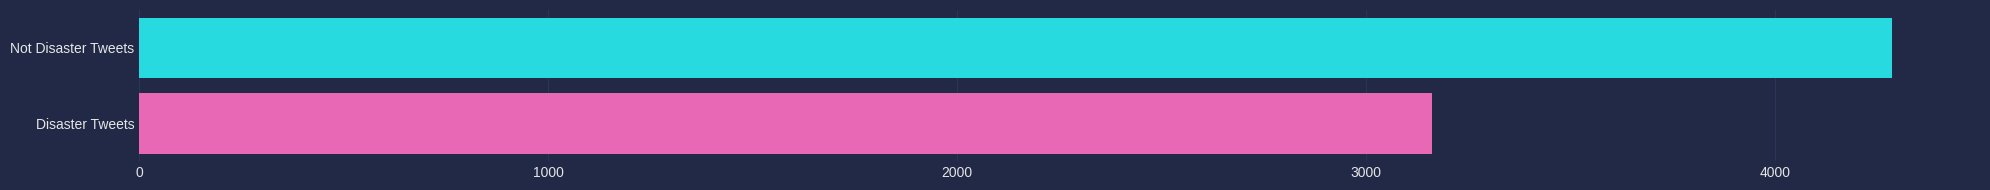

In [20]:
labels = ["Not Disaster Tweets", "Disaster Tweets",]
values = [df_cl[df_cl['target'] == 0].shape[0], df_cl[df_cl['target'] == 1].shape[0]]

plt.figure(figsize=(20, 2))
sns.barplot(y=labels, x=values)
plt.tight_layout();

## Word clouds

### Most frequent words in Disasters Tweets

In [21]:
aux = STOPWORDS.copy()
aux.update(["t"])
aux.update(["co"])
aux.update(["https"])
aux.update(["w"])
aux.update(["Û_"])
aux.update(["Û"])
aux.update(["U"])
aux.update(["ûᵃ"])
aux.update(["ûò"])

alltext = ' '.join(df_cl.loc[df_cl['target'] == 1, "text"])
word_cloud = WordCloud(width=1280, height=360, stopwords=aux, max_words=300).generate(text=alltext.lower())

plt.figure(figsize=(10, 20), dpi=2000)
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout();

### Most frequent words in Not Disasters Tweets

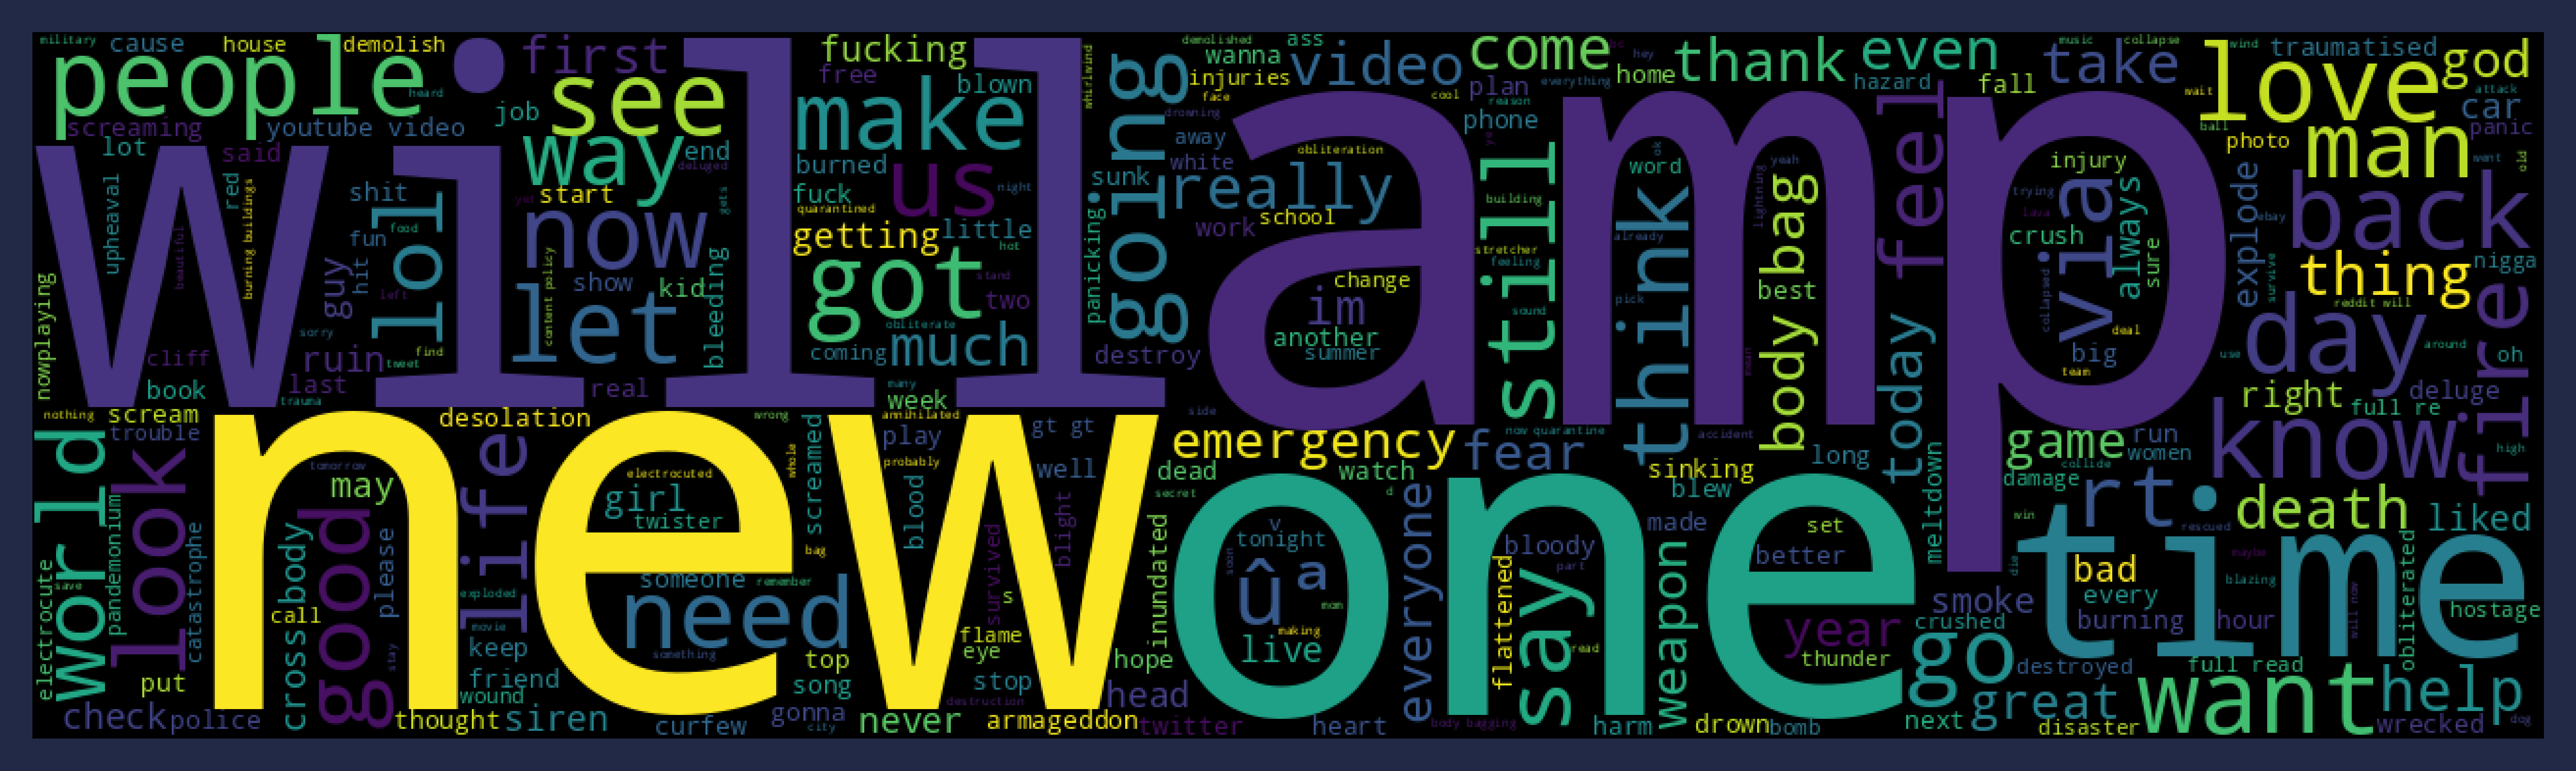

In [22]:
alltext = ' '.join(df_cl.loc[df_cl['target'] == 0, "text"])
word_cloud = WordCloud(width=1280, height=360, stopwords=aux, max_words=300).generate(text=alltext.lower())

fig = plt.figure(figsize=(10, 20), dpi=1000)
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

## Feature engineering

## spaCy for NLP

spaCy is a free, open-source library for advanced Natural Language Processing (NLP) in Python. It’s designed specifically for production use and helps you build applications that process and “understand” large volumes of text. It can be used to build information extraction or natural language understanding systems.

The processing pipeline consists of one or more pipeline components that are called on the Doc in order. The tokenizer runs before the components.

<img src="https://spacy.io/images/pipeline.svg" width=600>

### Working on the text of the tweets
#### Explaining the preprocessing pipeline that we will use in this project

1. Digits to words
2. Dealing with the Twitter mentions
3. Dealing with the hashtags
4. Dealing with the emoticons
5. Extracting, replacing and removing special and numerical characters, puntuactions, mentions, URLs and hashtags
6. Lemmatizing
7. Named-Entity Recognition
8. Lowercasing
9. Stopword removal
10. Tokenization
11. Padding sequence

In [3]:
raw_text="""Floods brought on by days of heavy rainfalls have been ravaging countries including Poland, Romania, 
            the Czech Republic and Austria, with thousands of people being evacuated as the death toll rises.
            Austrian Chancellor Karl Nehammer on Monday said in a post on social media platform X, 
            that was translated by CNBC, that two more people had died following floods in the country. 
            This is in addition to a firefighter who died Sunday."""

text1 = nlp(raw_text)   
displacy.render(text1, style="ent")

### Creating a example text

In [23]:
example_text = "Hello, my name is Alexander Daniel Rios. I'm 30 years old, and I live in Argentina. Currently, I am studying at National Technological University. You can find my GitHub profile at the following link: https://github.com/aletbm or with my username @aletbm. #DataScientist #MLZoomCamp ;) :-)"

## Digits to words

In [24]:
matcher = Matcher(nlp.vocab)

pattern = [{"IS_DIGIT": True}]
matcher.add("NUMBERS", [pattern])

def digits2words(text, to_print=False):
    doc = nlp(text)
    matches = matcher(doc)
    for match_id, start, end in matches:
        if doc.vocab.strings[match_id] == "NUMBERS":
            if to_print:
                text = text.replace(doc[start:end].text, '\033[4m\033[32m'+num2words(doc[start:end].text)+'\033[0m\033[100m')
            else:
                text = text.replace(doc[start:end].text, num2words(doc[start:end].text))
    return text

print(f"ORIGINAL TEXT\n\033[100m{example_text}\033[0m\n")
print(f"MODIFIED TEXT\n\033[100m{digits2words(example_text, to_print=True)}\033[0m")

ORIGINAL TEXT
Hello, my name is Alexander Daniel Rios. I'm 30 years old, and I live in Argentina. Currently, I am studying at National Technological University. You can find my GitHub profile at the following link: https://github.com/aletbm or with my username @aletbm. #DataScientist #MLZoomCamp ;) :-)

MODIFIED TEXT
Hello, my name is Alexander Daniel Rios. I'm thirty years old, and I live in Argentina. Currently, I am studying at National Technological University. You can find my GitHub profile at the following link: https://github.com/aletbm or with my username @aletbm. #DataScientist #MLZoomCamp ;) :-)


## Dealing with the Twitter mentions

In [25]:
pattern = [{"TEXT": {"REGEX":r"@\w+"}}]
matcher.add("TWITTER_MENTIONS", [pattern])

def replace_mentions(text):
    doc = nlp(text)
    matches = matcher(doc)
    for match_id, start, end in matches:
        if doc.vocab.strings[match_id] == "TWITTER_MENTIONS":
            text = text.replace(doc[start:end].text, "")#"@PERSON")
    return text

print(f"ORIGINAL TEXT\n\033[100m{example_text}\033[0m\n")
print(f"MODIFIED TEXT\n\033[100m{replace_mentions(example_text)}\033[0m")

ORIGINAL TEXT
Hello, my name is Alexander Daniel Rios. I'm 30 years old, and I live in Argentina. Currently, I am studying at National Technological University. You can find my GitHub profile at the following link: https://github.com/aletbm or with my username @aletbm. #DataScientist #MLZoomCamp ;) :-)

MODIFIED TEXT
Hello, my name is Alexander Daniel Rios. I'm 30 years old, and I live in Argentina. Currently, I am studying at National Technological University. You can find my GitHub profile at the following link: https://github.com/aletbm or with my username . #DataScientist #MLZoomCamp ;) :-)


## Dealing with the hashtags

In [26]:
pattern = [{'ORTH': '#'},{"TEXT": {"REGEX":r"\w+"}}]
matcher.add("HASHTAGS", [pattern])

def replace_hashtags(text, to_print=False):
    doc = nlp(text)
    matches = matcher(doc)
    for match_id, start, end in matches:
        if doc.vocab.strings[match_id] == "HASHTAGS":
            list_words = wn.split(doc[start+1:end].text)
            hashtag_converted = ' '.join(list_words)
            if to_print:
                text = text.replace(doc[start:end].text, '\033[4m\033[32m'+'#'+hashtag_converted+'\033[0m\033[100m')
            else:
                text = text.replace(doc[start:end].text, '#'+hashtag_converted)
    return text

print(f"ORIGINAL TEXT\n\033[100m{example_text}\033[0m\n")
print(f"MODIFIED TEXT\n\033[100m{replace_hashtags(example_text, to_print=True)}\033[0m")

ORIGINAL TEXT
Hello, my name is Alexander Daniel Rios. I'm 30 years old, and I live in Argentina. Currently, I am studying at National Technological University. You can find my GitHub profile at the following link: https://github.com/aletbm or with my username @aletbm. #DataScientist #MLZoomCamp ;) :-)

MODIFIED TEXT
Hello, my name is Alexander Daniel Rios. I'm 30 years old, and I live in Argentina. Currently, I am studying at National Technological University. You can find my GitHub profile at the following link: https://github.com/aletbm or with my username @aletbm. #Data Scientist #ML Zoom Camp ;) :-)


## Dealing with the emoticons

In [27]:
EMOTICONS = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
              ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
              ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
              ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
              '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
              '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
              ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

def replace_emojis(text, to_print=False):
    for emoji in EMOTICONS.keys():
        if to_print:
            text = text.replace(emoji, '\033[4m\033[32m'+ EMOTICONS[emoji]+'\033[0m\033[100m')
        else:
            text = text.replace(emoji, EMOTICONS[emoji])
    return text

print(f"ORIGINAL TEXT\n\033[100m{example_text}\033[0m\n")
print(f"MODIFIED TEXT\n\033[100m{replace_emojis(example_text, to_print=True)}\033[0m")

ORIGINAL TEXT
Hello, my name is Alexander Daniel Rios. I'm 30 years old, and I live in Argentina. Currently, I am studying at National Technological University. You can find my GitHub profile at the following link: https://github.com/aletbm or with my username @aletbm. #DataScientist #MLZoomCamp ;) :-)

MODIFIED TEXT
Hello, my name is Alexander Daniel Rios. I'm 30 years old, and I live in Argentina. Currently, I am studying at National Technological University. You can find my GitHub profile at the following link: https://github.com/aletbm or with my username @aletbm. #DataScientist #MLZoomCamp wink smile


## Extracting, replacing and removing special and numerical characters, puntuactions, mentions, URLs and hashtags

### On the Tweet texts

In [28]:
def get_list(text, c='#'):
    regex = ""
    if c == "https":
        regex = r"("+c+"?://[^\s]+)"
    elif c == "punct":
        regex = r"[!$%&´\'\"\(\)*,-./:;<=>?\\^_`\[\]{|}~+]"
    else:
        regex = r"("+c+"[^\s]+)"
    return re.findall(regex, text)

def clear_tweet(text, list_c):
    for c in list_c:
        if c in ["#", "@"]:
            lista = c
        else:
            lista = get_list(text, c)
        for item in lista:
            text = text.replace(item, " ").replace("  ", " ")
    text = re.sub(r'[^\x00-\x7F]+','', text)
    return text

def cleaner(text):
    hashtags = get_list(text, c='#')
    mentions = get_list(text, c='@')
    urls = get_list(text, c='https')
    clean_text = clear_tweet(text, ["#", "@", "https"])
    punctuations = get_list(clean_text, c="punct")
    clean_text = clear_tweet(clean_text, ["punct"])
    
    return clean_text, len(clean_text.split()), len(clean_text), len(hashtags), len(mentions), len(urls), len(punctuations)

#df_cl["clean_text"], df_cl["n_words"], df_cl["n_characters"], df_cl["n_hashtags"], df_cl["n_mentions"], df_cl["n_urls"], df_cl["n_punctuations"] = zip(*df_cl["text"].apply(cleaner))
clean_text, n_words, n_characters, n_hashtags, n_mentions, n_urls, n_punctuations = cleaner(example_text)

print(f"ORIGINAL TEXT\n\033[100m{example_text}\033[0m\n")
print(f"MODIFIED TEXT\n\033[100m{clean_text}\033[0m\n")
print(f"Number of words: {n_words}")
print(f"Number of characters: {n_characters}")
print(f"Number of hashtags: {n_hashtags}")
print(f"Number of mentions: {n_mentions}")
print(f"Number of URLs: {n_urls}")
print(f"Number of punctuations: {n_punctuations}")

ORIGINAL TEXT
Hello, my name is Alexander Daniel Rios. I'm 30 years old, and I live in Argentina. Currently, I am studying at National Technological University. You can find my GitHub profile at the following link: https://github.com/aletbm or with my username @aletbm. #DataScientist #MLZoomCamp ;) :-)

MODIFIED TEXT
Hello my name is Alexander Daniel Rios I m 30 years old and I live in Argentina Currently I am studying at National Technological University You can find my GitHub profile at the following link or with my username aletbm DataScientist MLZoomCamp 

Number of words: 42
Number of characters: 246
Number of hashtags: 2
Number of mentions: 1
Number of URLs: 1
Number of punctuations: 14


### On the keyword

In [29]:
df_cl.loc[df_cl.keyword.str.contains("%20"), "keyword"].unique()

array(['airplane%20accident', 'blew%20up', 'blown%20up', 'body%20bag',
       'body%20bagging', 'body%20bags', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire',
       'burning%20buildings', 'bush%20fires', 'chemical%20emergency',
       'cliff%20fall', 'dust%20storm', 'emergency%20plan',
       'emergency%20services', 'fire%20truck', 'first%20responders',
       'forest%20fire', 'forest%20fires', 'heat%20wave', 'loud%20bang',
       'mass%20murder', 'mass%20murderer', 'natural%20disaster',
       'nuclear%20disaster', 'nuclear%20reactor', 'oil%20spill',
       'radiation%20emergency', 'structural%20failure', 'suicide%20bomb',
       'suicide%20bomber', 'suicide%20bombing', 'violent%20storm',
       'war%20zone', 'wild%20fires'], dtype=object)

In [30]:
def replace_spaces(text):
    text = text.replace("%20", " ")
    return text

df_cl.loc[df_cl.keyword.str.contains("%20"), "keyword"].apply(replace_spaces).unique()

array(['airplane accident', 'blew up', 'blown up', 'body bag',
       'body bagging', 'body bags', 'bridge collapse',
       'buildings burning', 'buildings on fire', 'burning buildings',
       'bush fires', 'chemical emergency', 'cliff fall', 'dust storm',
       'emergency plan', 'emergency services', 'fire truck',
       'first responders', 'forest fire', 'forest fires', 'heat wave',
       'loud bang', 'mass murder', 'mass murderer', 'natural disaster',
       'nuclear disaster', 'nuclear reactor', 'oil spill',
       'radiation emergency', 'structural failure', 'suicide bomb',
       'suicide bomber', 'suicide bombing', 'violent storm', 'war zone',
       'wild fires'], dtype=object)

## Lemmatizing
### On the Tweet texts

In [31]:
def lemmatize(text):
    doc = nlp(text)
    for token in doc:
        text = text.replace(token.text, token.lemma_)
    return text

print(f"ORIGINAL TEXT\n\033[100m{example_text}\033[0m\n")
print(f"MODIFIED TEXT\n\033[100m{lemmatize(example_text)}\033[0m")

ORIGINAL TEXT
Hello, my name is Alexander Daniel Rios. I'm 30 years old, and I live in Argentina. Currently, I am studying at National Technological University. You can find my GitHub profile at the following link: https://github.com/aletbm or with my username @aletbm. #DataScientist #MLZoomCamp ;) :-)

MODIFIED TEXT
hello, my nbee be Alexander Daniel Rios. Ibe 30 year old, and I live in Argentina. currently, I be study at National Technological University. you can find my GitHub profile at the follow link: https://github.com/aletbm or with my usernbee @aletbm. #DataScientbet #MLZoomCbep ;) :-)


### On the keyword

In [32]:
df_cl.keyword.apply(replace_spaces).unique()[-10:]

array(['weapons', 'whirlwind', 'wild fires', 'wildfire', 'windstorm',
       'wounded', 'wounds', 'wreck', 'wreckage', 'wrecked'], dtype=object)

In [33]:
df_cl.keyword.apply(replace_spaces).apply(lemmatize).unique()[-10:]

array(['volcano', 'war zone', 'weapon', 'whirlwind', 'wild fire',
       'wildfire', 'windstorm', 'wound', 'wreck', 'wreckage'],
      dtype=object)

## Named-Entity Recognition

In [34]:
def replace_entities(text, to_print=False):
    doc = nlp(text)
    for ent in doc.ents:
        if to_print:
            text = text.replace(ent.text, '\033[4m\033[32m'+ent.label_+'\033[0m\033[100m')
        else:
            text = text.replace(ent.text, ent.label_)
    return text

print(f"ORIGINAL TEXT\n\033[100m{example_text}\033[0m\n")
print(f"MODIFIED TEXT\n\033[100m{replace_entities(example_text, to_print=True)}\033[0m")

ORIGINAL TEXT
Hello, my name is Alexander Daniel Rios. I'm 30 years old, and I live in Argentina. Currently, I am studying at National Technological University. You can find my GitHub profile at the following link: https://github.com/aletbm or with my username @aletbm. #DataScientist #MLZoomCamp ;) :-)

MODIFIED TEXT
Hello, my name is PERSON. I'm DATE, and I live in GPE. Currently, I am studying at ORG. You can find my ORG profile at the following link: https://github.com/aletbm or with my username ORG. MONEYMLZoomCamp ;) :-)


## Lowercasing

In [35]:
print(f"ORIGINAL TEXT\n\033[100m{example_text}\033[0m\n")
print(f"MODIFIED TEXT\n\033[100m{example_text.lower()}\033[0m")

ORIGINAL TEXT
Hello, my name is Alexander Daniel Rios. I'm 30 years old, and I live in Argentina. Currently, I am studying at National Technological University. You can find my GitHub profile at the following link: https://github.com/aletbm or with my username @aletbm. #DataScientist #MLZoomCamp ;) :-)

MODIFIED TEXT
hello, my name is alexander daniel rios. i'm 30 years old, and i live in argentina. currently, i am studying at national technological university. you can find my github profile at the following link: https://github.com/aletbm or with my username @aletbm. #datascientist #mlzoomcamp ;) :-)


## Stopword removal

In [36]:
def remove_stopwords(text):
    doc = nlp(text)
    filtered_sentence = []
    for token in doc:
        if (token.is_stop == False
            and len(token) > 2
            and token.is_ascii
            and token.is_alpha
            and token.text in dict_words[token.text[0]][token.text[1]]):
            filtered_sentence.append(token.text)
                
    return ' '.join(filtered_sentence)

print(f"ORIGINAL TEXT\n\033[100m{example_text.lower()}\033[0m\n")
print(f"MODIFIED TEXT\n\033[100m{remove_stopwords(example_text.lower())}\033[0m")

ORIGINAL TEXT
hello, my name is alexander daniel rios. i'm 30 years old, and i live in argentina. currently, i am studying at national technological university. you can find my github profile at the following link: https://github.com/aletbm or with my username @aletbm. #datascientist #mlzoomcamp ;) :-)

MODIFIED TEXT
hello alexander daniel years old live argentina currently studying national technological university find profile following link


## Tokenization

In [37]:
def tokenize(text, tokenizer, fit=False):
    if fit == True:
        tokenizer.fit_on_texts(text)
    return tokenizer.texts_to_sequences(text)

tokenizer = Tokenizer(oov_token="<OOV>")
tokenized_text = tokenize([example_text], tokenizer, fit=True)

print(f"ORIGINAL TEXT\n\033[100m{example_text}\033[0m\n")
print(f"TOKENIZED TEXT\n\033[100m{tokenized_text}\033[0m\n")
print(f"DICTONARY OF CONVERTION\n\033[100m{dict(itertools.islice(tokenizer.index_word.items(), 150))}\033[0m")

ORIGINAL TEXT
Hello, my name is Alexander Daniel Rios. I'm 30 years old, and I live in Argentina. Currently, I am studying at National Technological University. You can find my GitHub profile at the following link: https://github.com/aletbm or with my username @aletbm. #DataScientist #MLZoomCamp ;) :-)

TOKENIZED TEXT
[[7, 2, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 3, 18, 19, 20, 21, 3, 22, 23, 4, 24, 25, 26, 27, 28, 29, 2, 5, 30, 4, 31, 32, 33, 34, 5, 35, 6, 36, 37, 2, 38, 6, 39, 40]]

DICTONARY OF CONVERTION
{1: '<OOV>', 2: 'my', 3: 'i', 4: 'at', 5: 'github', 6: 'aletbm', 7: 'hello', 8: 'name', 9: 'is', 10: 'alexander', 11: 'daniel', 12: 'rios', 13: "i'm", 14: '30', 15: 'years', 16: 'old', 17: 'and', 18: 'live', 19: 'in', 20: 'argentina', 21: 'currently', 22: 'am', 23: 'studying', 24: 'national', 25: 'technological', 26: 'university', 27: 'you', 28: 'can', 29: 'find', 30: 'profile', 31: 'the', 32: 'following', 33: 'link', 34: 'https', 35: 'com', 36: 'or', 37: 'with', 38: 'username', 39

## Padding sequence

In [38]:
max_length_tweet = 21*3

padded_text = pad_sequences(tokenized_text, maxlen=max_length_tweet, padding='post')

print(f"TOKENIZED TEXT\n\033[100m{tokenized_text}\033[0m\n")
print(f"TEXT WITH PADDING\n\033[100m{padded_text}\033[0m")

TOKENIZED TEXT
[[7, 2, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 3, 18, 19, 20, 21, 3, 22, 23, 4, 24, 25, 26, 27, 28, 29, 2, 5, 30, 4, 31, 32, 33, 34, 5, 35, 6, 36, 37, 2, 38, 6, 39, 40]]

TEXT WITH PADDING
[[ 7  2  8  9 10 11 12 13 14 15 16 17  3 18 19 20 21  3 22 23  4 24 25 26
  27 28 29  2  5 30  4 31 32 33 34  5 35  6 36 37  2 38  6 39 40  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]


## All preprocessing steps in a single function

### Cleaning the Tweet text

In [39]:
def init_configure():
    matcher = Matcher(nlp.vocab)
    
    pattern = [{"IS_DIGIT": True}]
    matcher.add("NUMBERS", [pattern])
    
    pattern = [{"TEXT": {"REGEX":r"@\w+"}}]
    matcher.add("TWITTER_MENTIONS", [pattern])
    
    pattern = [{'ORTH': '#'},{"TEXT": {"REGEX":r"\w+"}}]
    matcher.add("HASHTAGS", [pattern])
    
    tokenizer = Tokenizer(oov_token="<OOV>")
    
    max_length_tweet = 21*5
    max_length_keyword = 3*2
    return matcher, tokenizer, max_length_tweet, max_length_keyword

def preprocessing_text(text):
    doc = nlp(text)
    matches = matcher(doc)
    for match_id, start, end in matches:
        if doc.vocab.strings[match_id] == "NUMBERS":
            text = text.replace(doc[start:end].text, num2words(doc[start:end].text))
        #if doc.vocab.strings[match_id] == "TWITTER_MENTIONS":
        #    text = text.replace(doc[start:end].text, "")#"@PERSON")
        #if doc.vocab.strings[match_id] == "HASHTAGS":
            #list_words = wn.split(doc[start+1:end].text)
            #hashtag_converted = ' '.join(list_words)
            #text = text.replace(doc[start:end].text, '#'+hashtag_converted)
            
    #text = replace_emojis(text)
    text, n_words, n_characters, n_hashtags, n_mentions, n_urls, n_punctuations = cleaner(text)
    text = lemmatize(text)
    #text = replace_entities(text)
    text = text.lower()
    clean_text = remove_stopwords(text)
        
    return clean_text, n_words, n_characters, n_hashtags, n_mentions, n_urls, n_punctuations

def preprocessing_keyword(text, tokenization=False, fit=False, padding=False):
    text = replace_spaces(text)
    clean_text = lemmatize(text)
    return clean_text

matcher, tokenizer, max_length_tweet, max_length_keyword = init_configure()

df_cl["clean_text"], df_cl["n_words"], df_cl["n_characters"], df_cl["n_hashtags"], df_cl["n_mentions"], df_cl["n_urls"], df_cl["n_punctuations"] = zip(*df_cl["text"].apply(lambda text: preprocessing_text(text)))
df_cl["clean_keyword"] = df_cl.keyword.apply(lambda text: preprocessing_keyword(text))
df_cl.head()

,keyword,text,target,clean_text,n_words,n_characters,n_hashtags,n_mentions,n_urls,n_punctuations,clean_keyword
id,,,,,,,,,,,
48,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,wholesale markets ablaze,4,33,0,1,1,0,ablaze
49,ablaze,We always try to bring the heavy. #metal #RT h...,0,try bring heavy metal,9,42,2,0,1,1,ablaze
50,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,break news nigeria flag set ablaze,9,58,1,0,1,3,ablaze
52,ablaze,Crying out for more! Set me ablaze,0,cry set ablaze,7,33,0,0,0,1,ablaze
53,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,plus look sky night ablaze,12,54,0,0,1,0,ablaze


### Tokenization and Padding

In [40]:
def get_tokens(text, max_length, fit=False, padding=False):
    preprocessed_text = tokenize(text, tokenizer, fit)
    if padding:
        preprocessed_text = pad_sequences(preprocessed_text, maxlen=max_length, padding='post')
    return preprocessed_text

df_cl["tokenized_text"] = list(get_tokens(df_cl["clean_text"].tolist(), max_length=max_length_tweet, fit=True, padding=True))
df_cl["tokenized_keyword"] = list(get_tokens(df_cl["clean_keyword"].tolist(), max_length=max_length_keyword, fit=True, padding=True))
df_cl.head()

,keyword,text,target,clean_text,n_words,n_characters,n_hashtags,n_mentions,n_urls,n_punctuations,clean_keyword,tokenized_text,tokenized_keyword
id,,,,,,,,,,,,,
48,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,wholesale markets ablaze,4,33,0,1,1,0,ablaze,"[2049, 2468, 417, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[214, 0, 0, 0, 0, 0]"
49,ablaze,We always try to bring the heavy. #metal #RT h...,0,try bring heavy metal,9,42,2,0,1,1,ablaze,"[123, 327, 608, 858, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[214, 0, 0, 0, 0, 0]"
50,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,break news nigeria flag set ablaze,9,58,1,0,1,3,ablaze,"[111, 7, 1737, 472, 119, 417, 0, 0, 0, 0, 0, 0...","[214, 0, 0, 0, 0, 0]"
52,ablaze,Crying out for more! Set me ablaze,0,cry set ablaze,7,33,0,0,0,1,ablaze,"[644, 119, 417, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[214, 0, 0, 0, 0, 0]"
53,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,plus look sky night ablaze,12,54,0,0,1,0,ablaze,"[1229, 22, 645, 165, 417, 0, 0, 0, 0, 0, 0, 0,...","[214, 0, 0, 0, 0, 0]"


### Vocabulary size

In [41]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8826

### Let's take a look at the vocabulary

In [42]:
pprint(dict(itertools.islice(tokenizer.index_word.items(), 20)))

{1: '<OOV>',
 2: 'fire',
 3: 'like',
 4: 'amp',
 5: 'thousand',
 6: 'emergency',
 7: 'burn',
 8: 'body',
 9: 'bomb',
 10: 'disaster',
 11: 'crash',
 12: 'storm',
 13: 'flood',
 14: 'new',
 15: 'attack',
 16: 'collapse',
 17: 'building',
 18: 'scream',
 19: 'suicide',
 20: 'drown'}


## N-grams
N-grams are contiguous sequences of ’n’ items, typically words in the context of NLP.
<img src="https://i.postimg.cc/zfmLzhrF/0-Omgvdgf-H-6y-HAVG.png">

### Unigrams

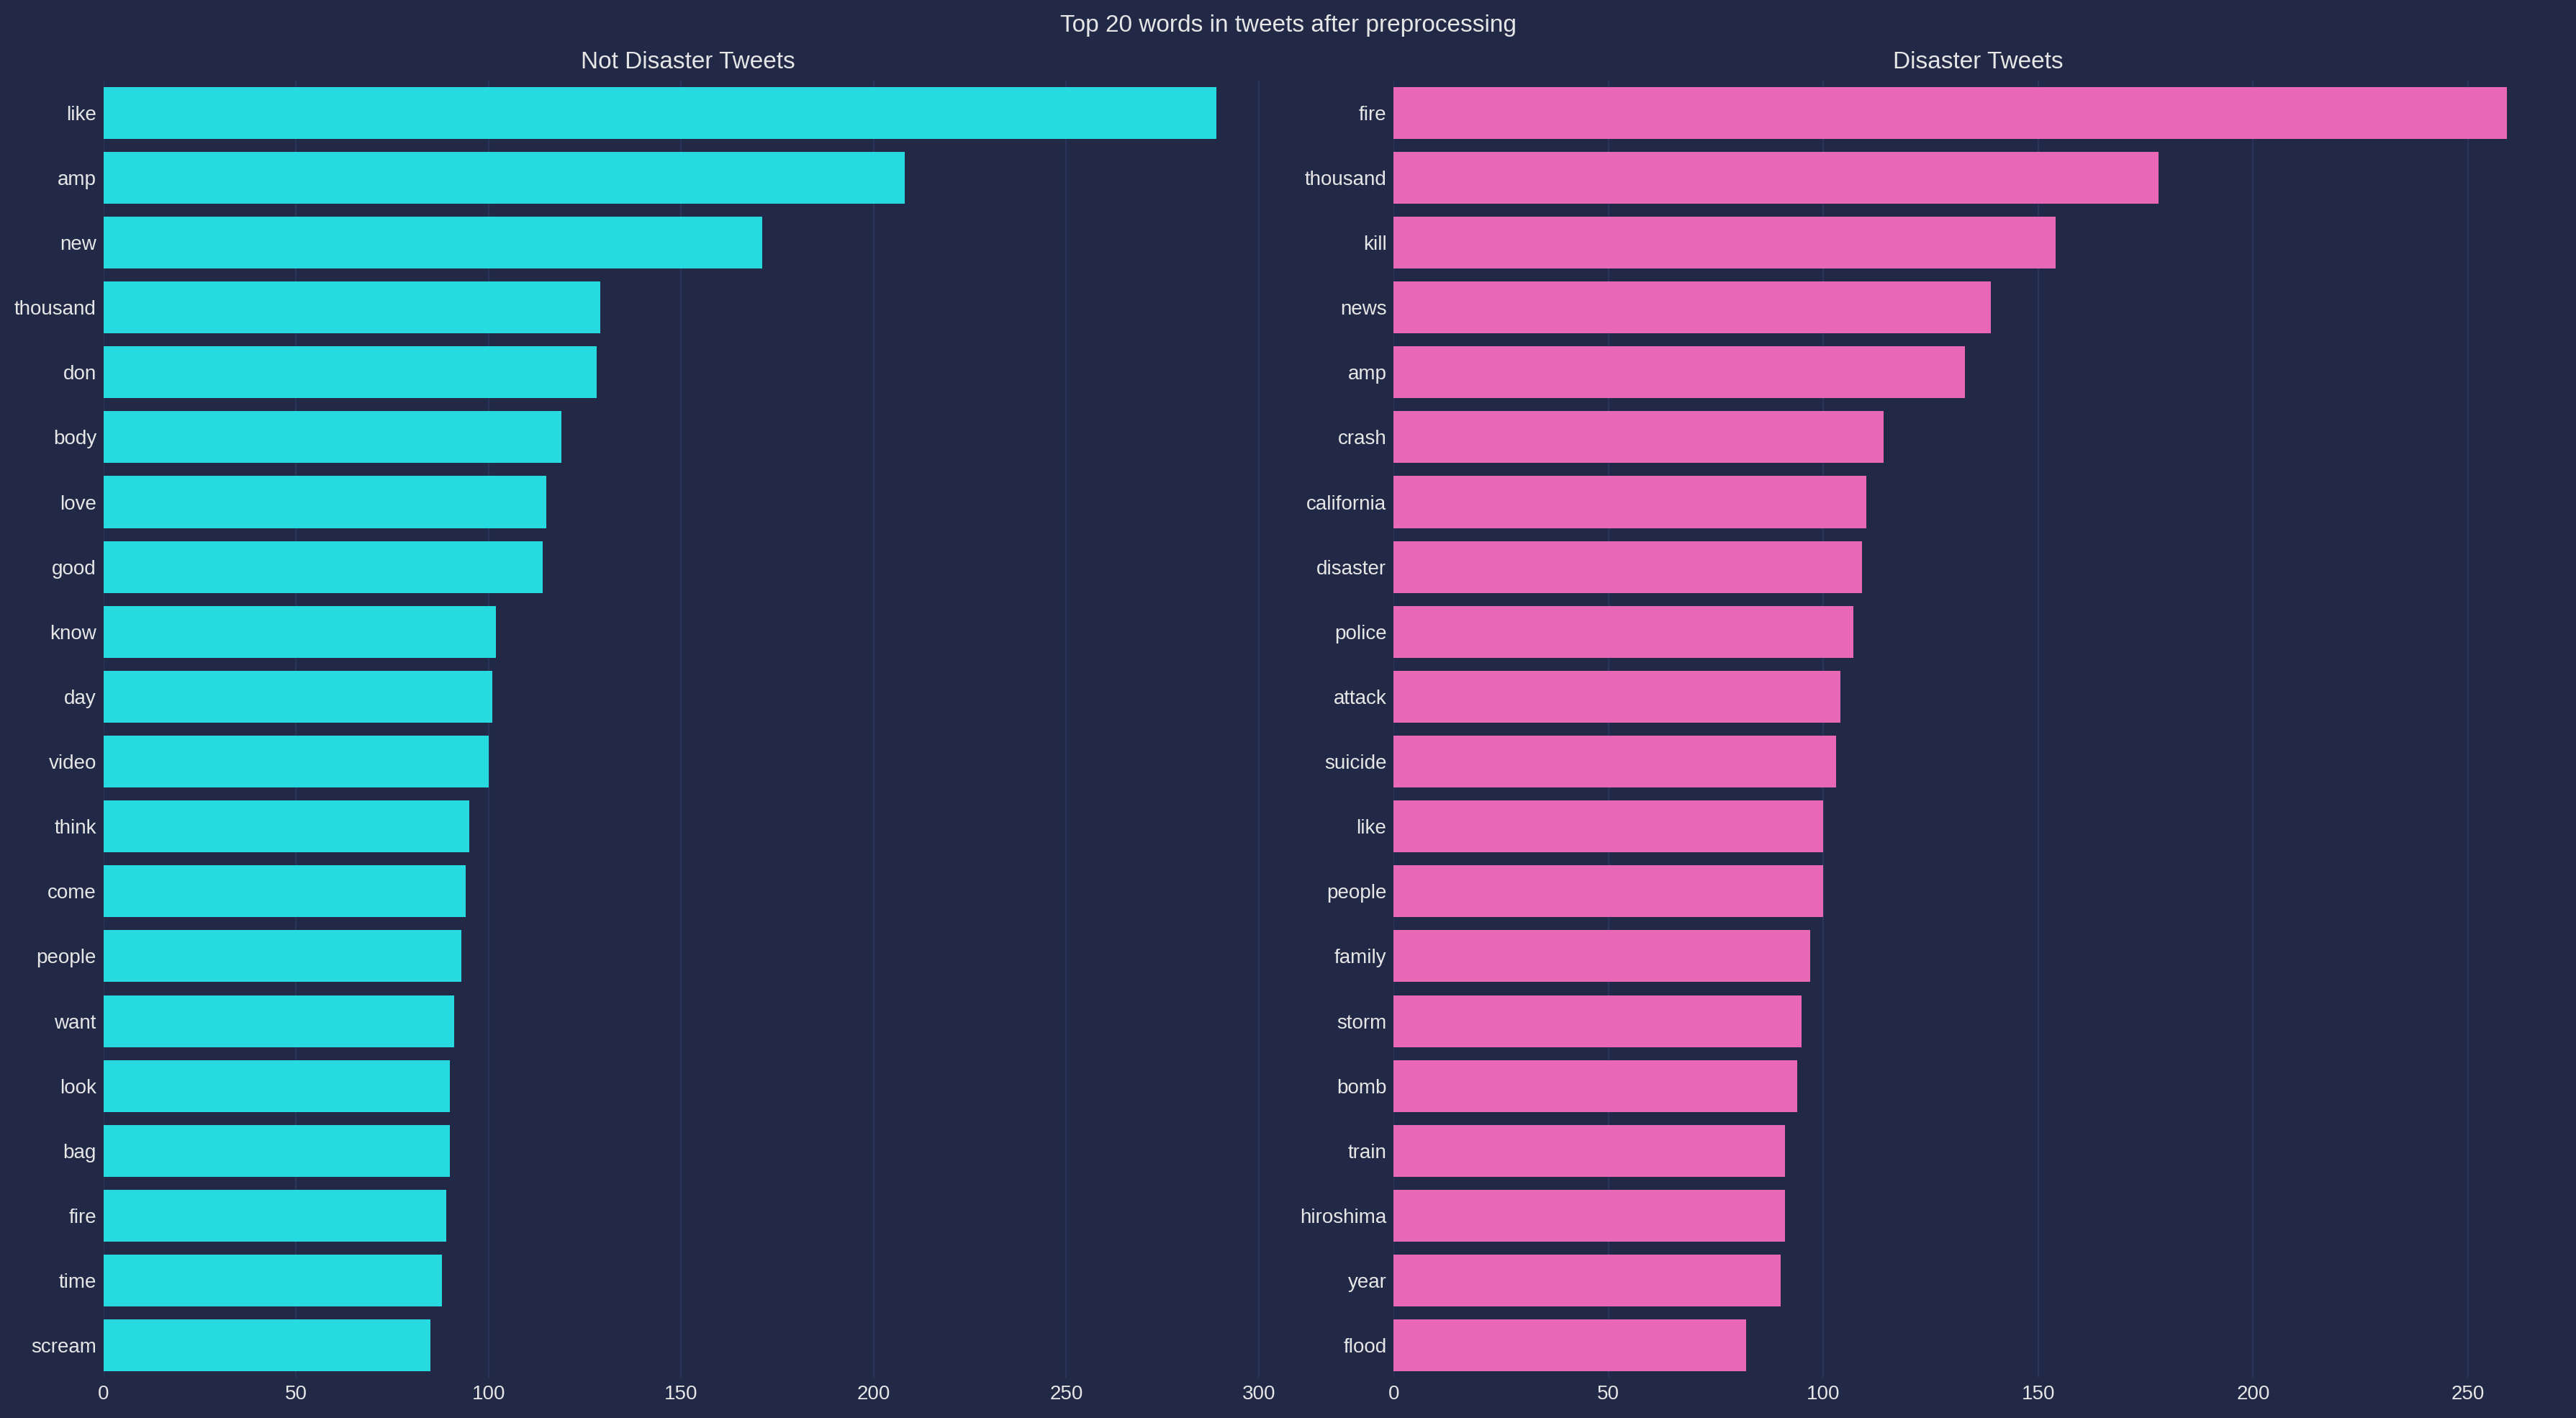

In [43]:
def get_top_n_words(data, ngram_range=(1, 1)):
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    count_matrix = vectorizer.fit_transform(data)
    count_array = count_matrix.toarray()
    bag_of_words = pd.DataFrame(data=count_array,columns = vectorizer.get_feature_names_out(), index=df_cl.index)
    return bag_of_words

bag_of_words = get_top_n_words(data=df_cl['clean_text'], ngram_range=(1, 1))

#pos_list = ["CARDINAL", "DATE", "EVENT", "FAC", "GPE", "LANGUAGE", "LAW",
#            "LOC", "MONEY", "NORP", "ORDINAL", "ORG", "PERCENT", "PERSON",
#            "QUANTITY", "TIME", "WORK_OF_ART", "LOC", "MISC", "ORG", "PER"]
#pos_list = [pos.lower() for pos in pos_list]
def plot_top_words(data, bag_of_words, top=20):
    top_word_disaster = bag_of_words[data["target"] == 1].sum().sort_values(ascending=False)
    top_word_disaster = top_word_disaster[:top]
    
    top_word_notdisaster = bag_of_words[data["target"] == 0].sum().sort_values(ascending=False)
    top_word_notdisaster = top_word_notdisaster[:top]
    
    plt.subplots(1, 2, figsize=(18, 10), dpi=200)
    
    plt.subplot(1, 2, 1)
    sns.barplot(y=top_word_notdisaster.index, x=top_word_notdisaster, color='#08F7FE')
    plt.title("Not Disaster Tweets")
    
    plt.subplot(1, 2, 2)
    sns.barplot(y=top_word_disaster.index, x=top_word_disaster, color='#FE53BB')
    plt.title("Disaster Tweets");
    plt.suptitle(f"Top {top} words in tweets after preprocessing")
    plt.tight_layout()

plot_top_words(data=df_cl, bag_of_words=bag_of_words, top=20)

### Bigrams

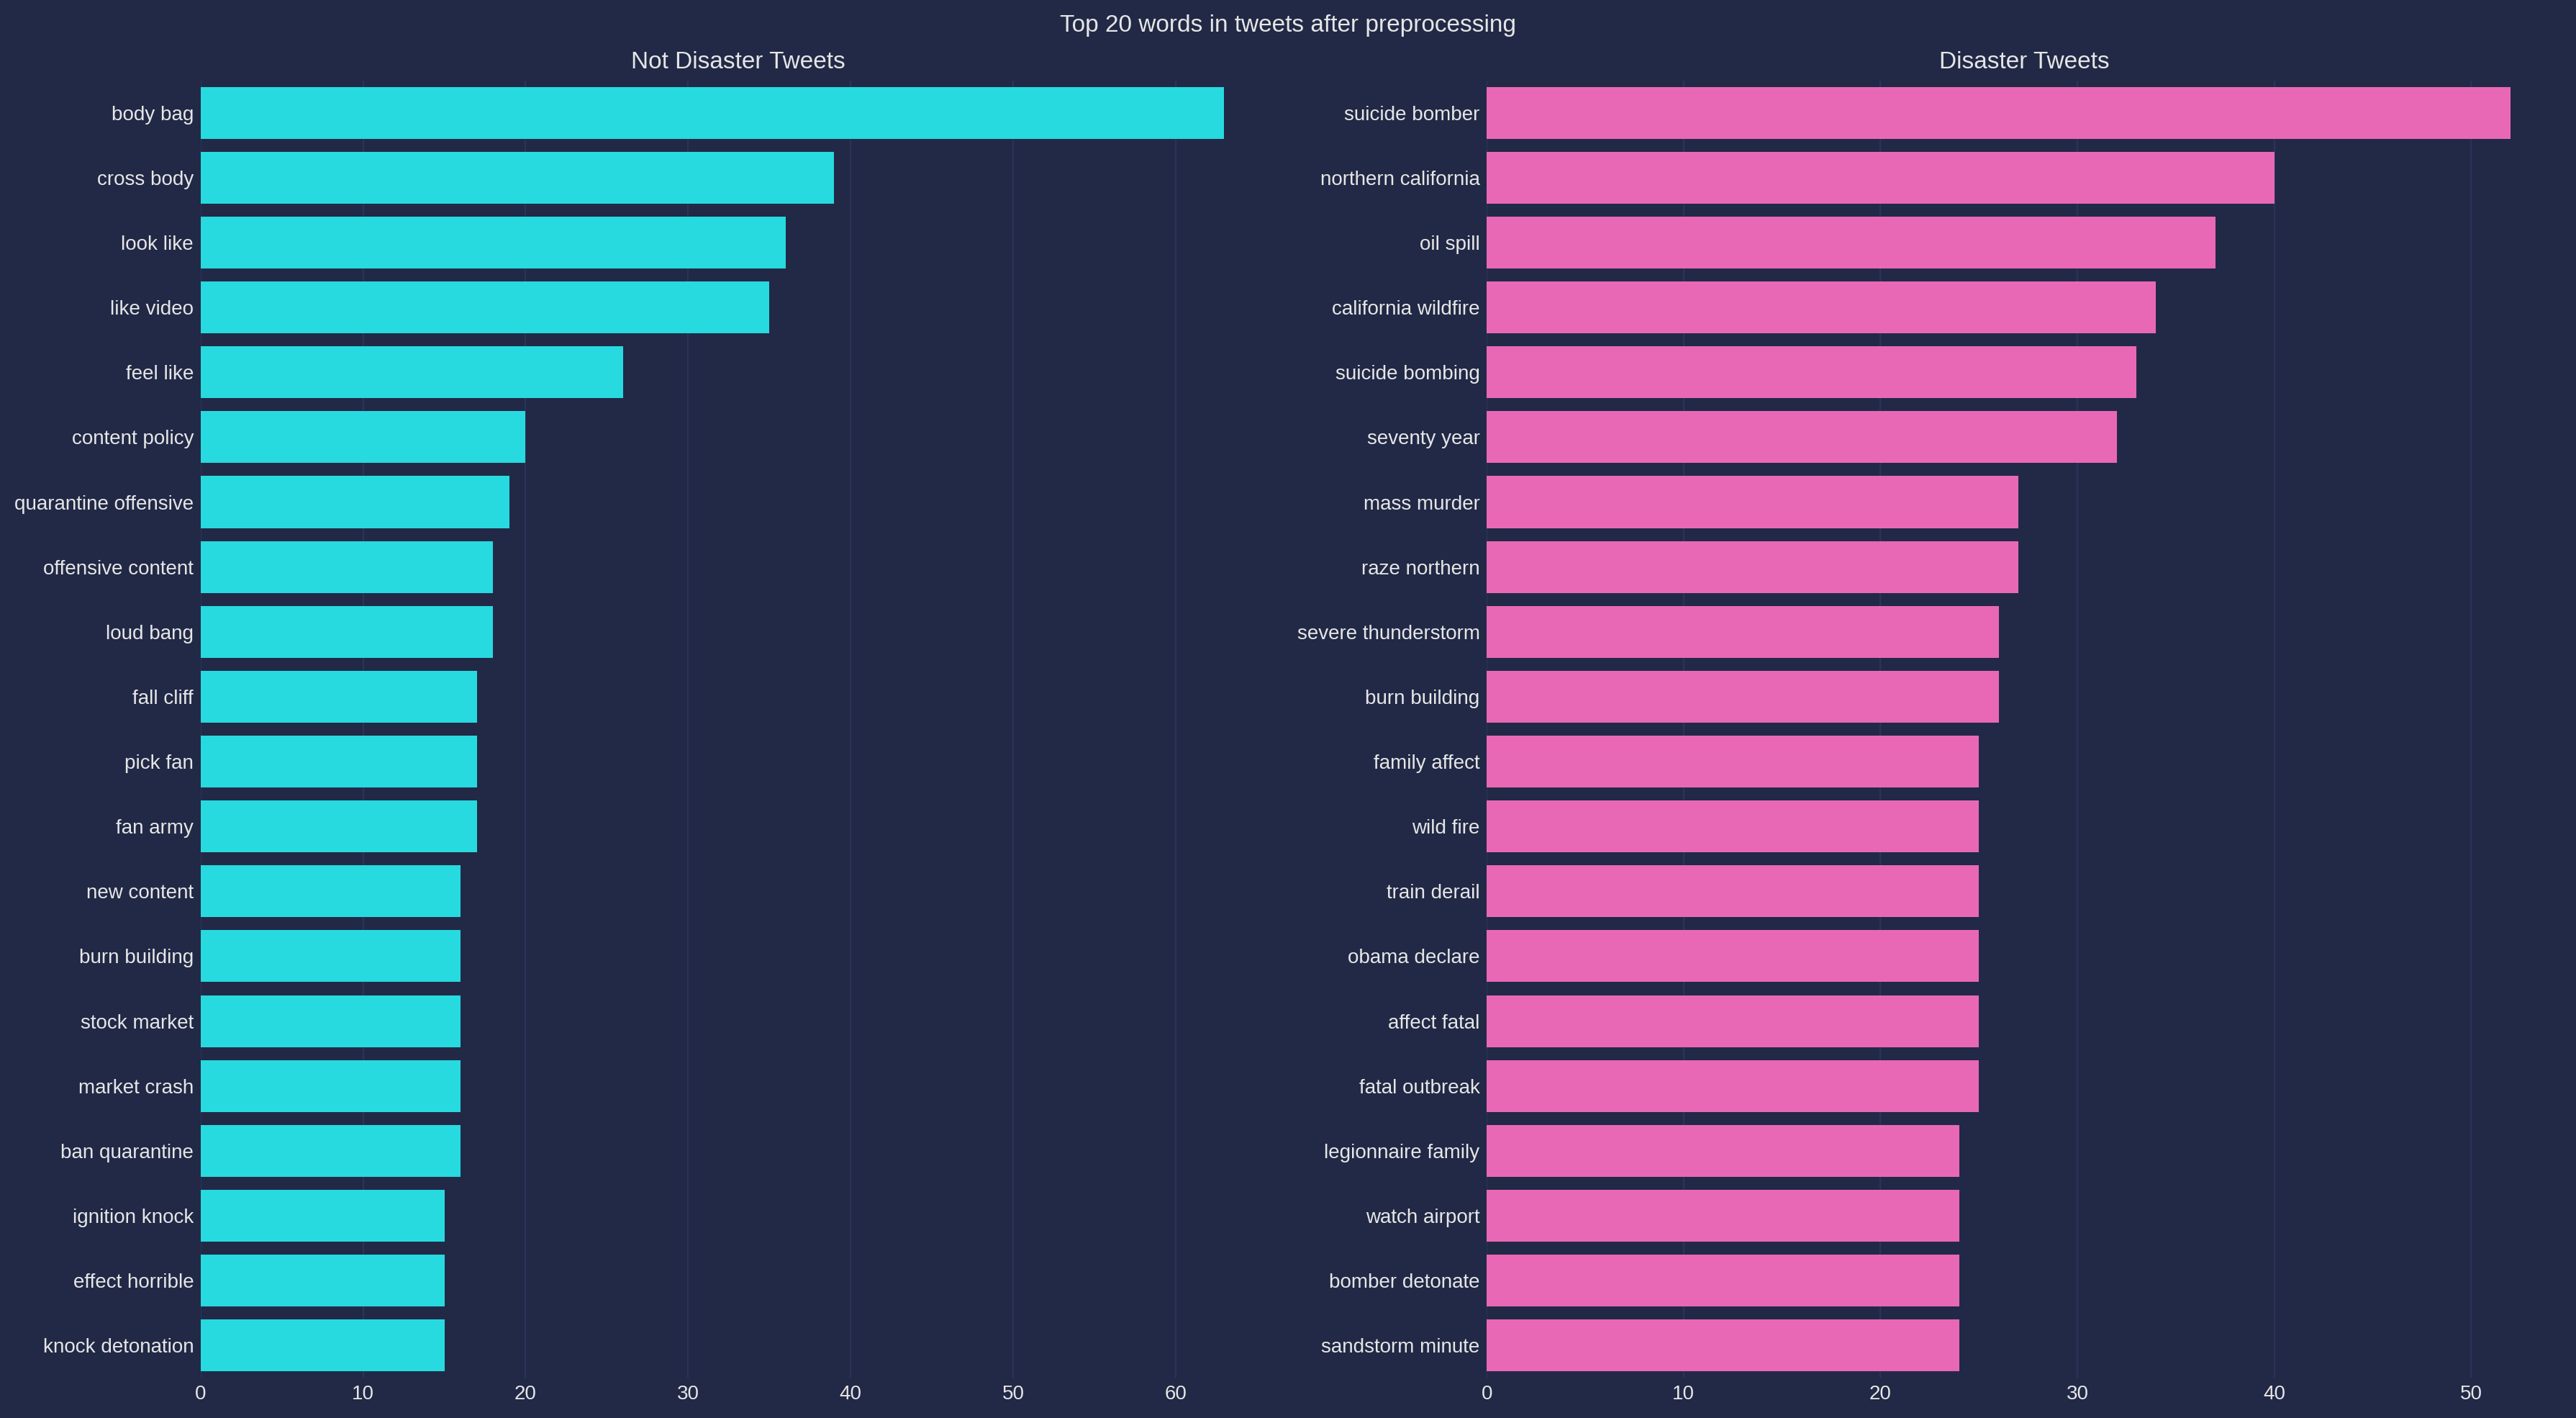

In [44]:
bag_of_words = get_top_n_words(data=df_cl['clean_text'], ngram_range=(2, 2))
plot_top_words(data=df_cl, bag_of_words=bag_of_words, top=20)

### Trigrams

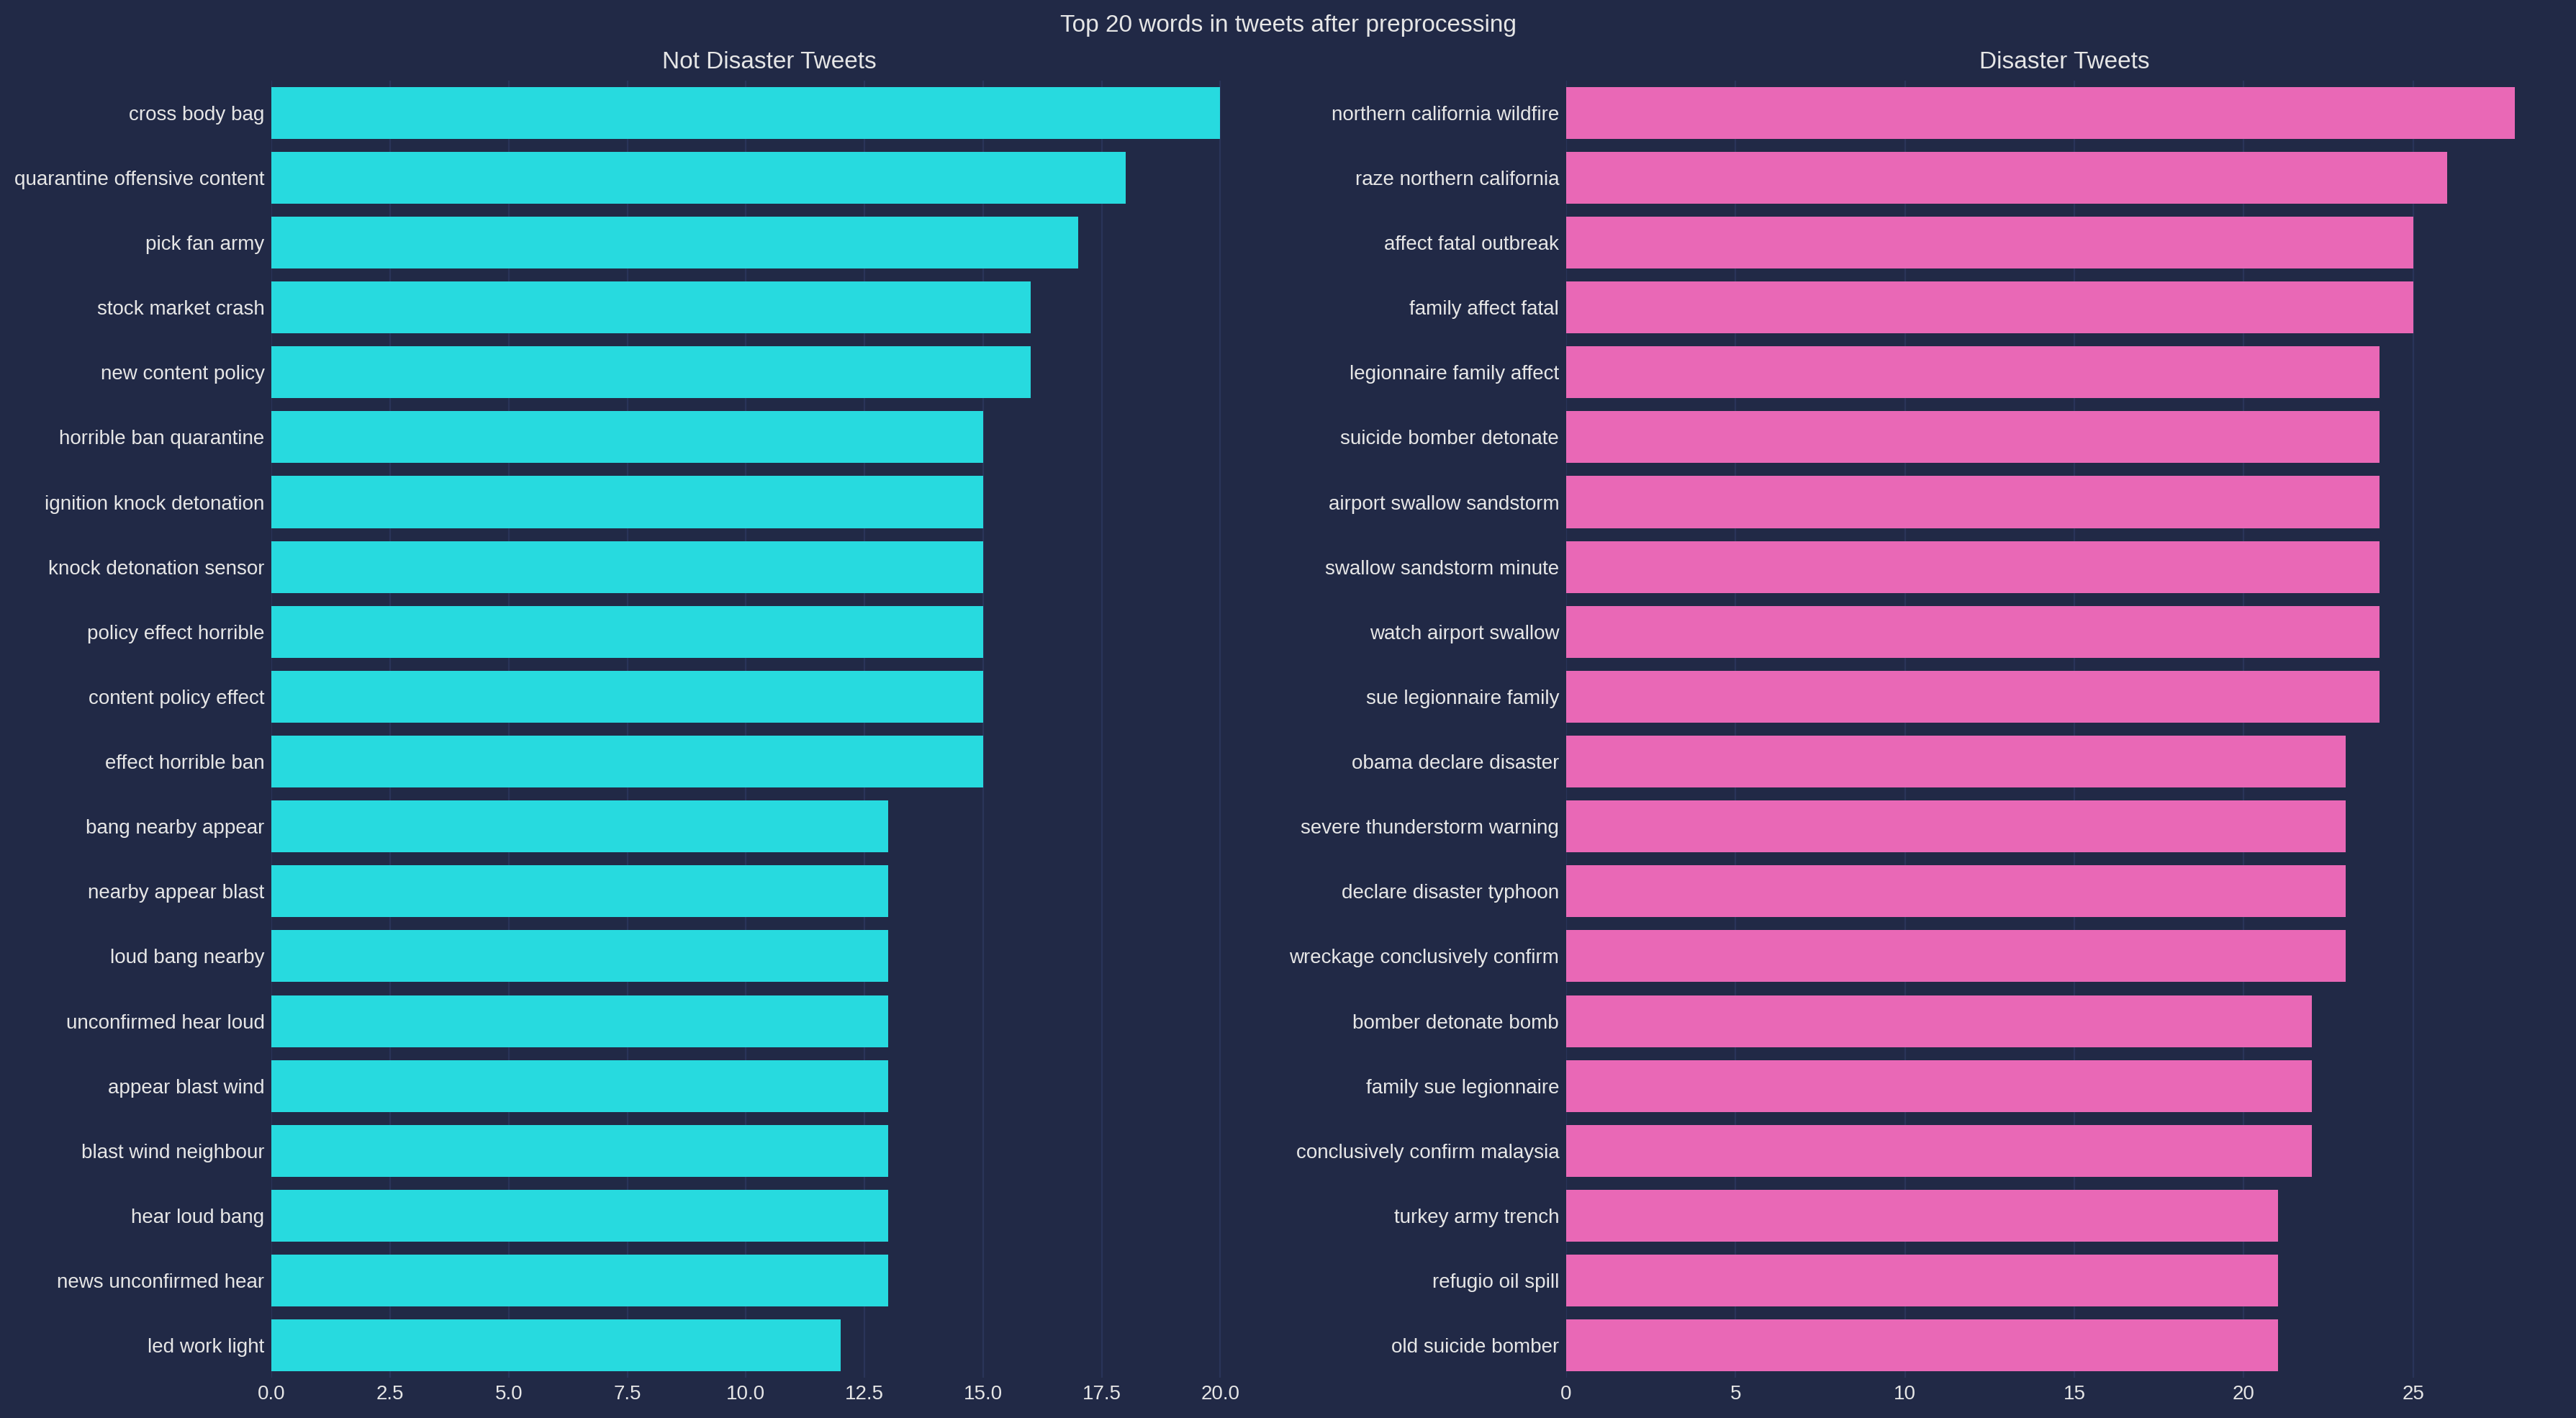

In [45]:
bag_of_words = get_top_n_words(data=df_cl['clean_text'], ngram_range=(3, 3))
plot_top_words(data=df_cl, bag_of_words=bag_of_words, top=20)

## Distribution of the context feature by tweet type

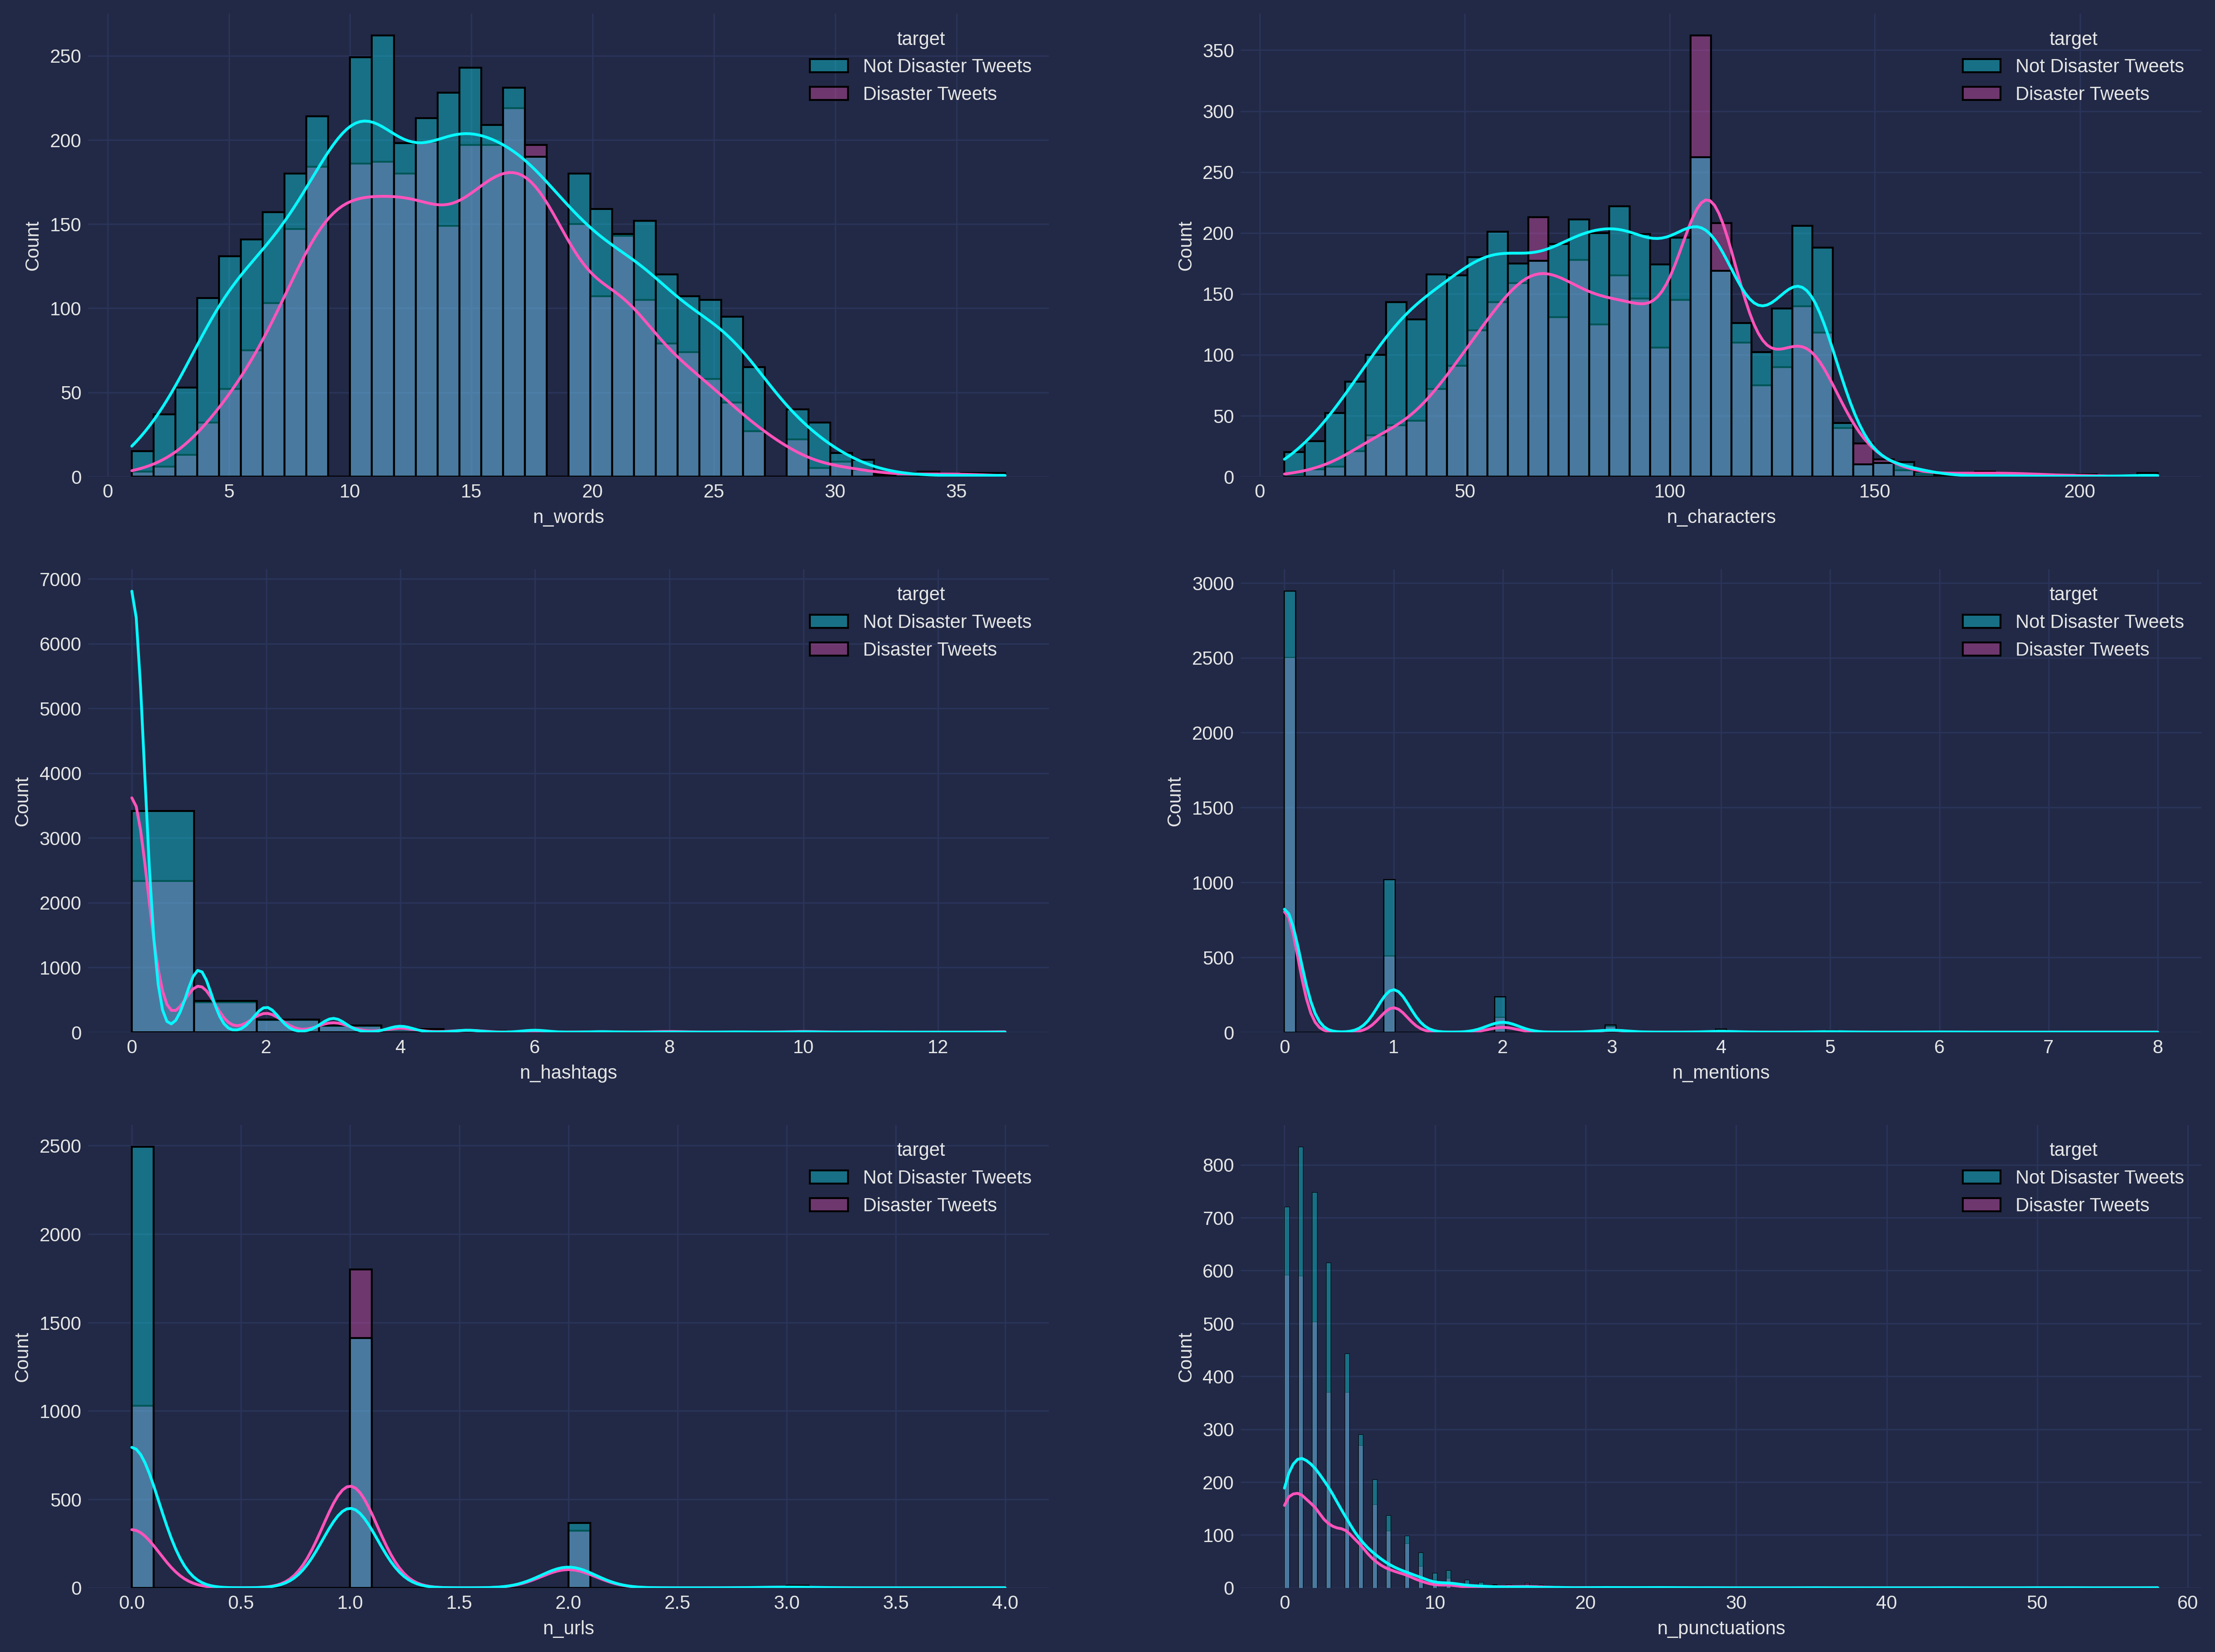

In [46]:
pd.set_option("mode.copy_on_write", False)
target = df_cl["target"].map({0: "Not Disaster Tweets", 1: "Disaster Tweets"})

plt.subplots(3, 2, figsize=(20, 15), dpi=300)
for i, col in enumerate(["n_words", "n_characters", "n_hashtags", "n_mentions", "n_urls", "n_punctuations"]):
    plt.subplot(3, 2, i+1)
    sns.histplot(x=df_cl[col], hue=target, hue_order=["Not Disaster Tweets", "Disaster Tweets"], alpha=0.35, kde=True);

# Splitting the dataset
## Separating the target

In [47]:
X = df_cl.drop(["target"], axis=1)
y = df_cl["target"]

## Creating the training and validation set

In [48]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, stratify=y, shuffle=True, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.50, stratify=y_val, shuffle=True, random_state=seed)
X_train.head()

,keyword,text,clean_text,n_words,n_characters,n_hashtags,n_mentions,n_urls,n_punctuations,clean_keyword,tokenized_text,tokenized_keyword
id,,,,,,,,,,,,
3015,death,I feel like death,feel like death,4,17,0,0,0,0,death,"[81, 2, 36, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[23, 0, 0, 0, 0, 0]"
276,ambulance,#reuters Twelve feared killed in Pakistani air...,reuters fear kill pakistani air ambulance heli...,10,74,1,0,1,0,ambulance,"[560, 61, 10, 727, 227, 242, 439, 12, 0, 0, 0,...","[137, 0, 0, 0, 0, 0]"
3075,deaths,real magic in real life:\n\nwomen went missing...,real magic real life woman miss ohio town focu...,20,106,0,0,1,4,death,"[251, 1442, 251, 38, 128, 188, 2612, 540, 1472...","[23, 0, 0, 0, 0, 0]"
2209,chemical%20emergency,Emergency Response and Hazardous Chemical Mana...,emergency response hazardous chemical manageme...,9,78,0,0,2,1,chemical emergency,"[13, 878, 364, 278, 1895, 5292, 993, 0, 0, 0, ...","[175, 6, 0, 0, 0, 0]"
996,blazing,SHOUOUT TO @kasad1lla CAUSE HER VOCALS ARE BLA...,cause vocals blaze hot like weather,14,78,0,1,0,0,blaze,"[47, 4799, 187, 99, 2, 175, 0, 0, 0, 0, 0, 0, ...","[70, 0, 0, 0, 0, 0]"


## Dealing with an imbalance target

In [49]:
class_weight = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight = dict(zip(np.unique(y_train), class_weight))
class_weight

{0: 0.8688739789964994, 1: 1.1777382364570976}

# Training a baseline model for Tweet classification

## Creating the dataset for my baseline model
### Selecting the useful columns

In [65]:
X_train_tokenized = X_train.loc[:, ["tokenized_text", "tokenized_keyword", "n_words", "n_characters", "n_hashtags", "n_mentions", "n_urls", "n_punctuations"]]
X_val_tokenized = X_val.loc[:, ["tokenized_text", "tokenized_keyword", "n_words", "n_characters", "n_hashtags", "n_mentions", "n_urls", "n_punctuations"]]
X_test_tokenized = X_test.loc[:, ["tokenized_text", "tokenized_keyword", "n_words", "n_characters", "n_hashtags", "n_mentions", "n_urls", "n_punctuations"]]

X_train_tokenized.head()

,tokenized_text,tokenized_keyword,n_words,n_characters,n_hashtags,n_mentions,n_urls,n_punctuations
id,,,,,,,,
3015,"[81, 2, 36, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[23, 0, 0, 0, 0, 0]",4,17,0,0,0,0
276,"[560, 61, 10, 727, 227, 242, 439, 12, 0, 0, 0,...","[137, 0, 0, 0, 0, 0]",10,74,1,0,1,0
3075,"[251, 1442, 251, 38, 128, 188, 2612, 540, 1472...","[23, 0, 0, 0, 0, 0]",20,106,0,0,1,4
2209,"[13, 878, 364, 278, 1895, 5292, 993, 0, 0, 0, ...","[175, 6, 0, 0, 0, 0]",9,78,0,0,2,1
996,"[47, 4799, 187, 99, 2, 175, 0, 0, 0, 0, 0, 0, ...","[70, 0, 0, 0, 0, 0]",14,78,0,1,0,0


### Creating a Tensorflow Dataset

In [113]:
train_text, train_keyword, train_context = X_train_tokenized["tokenized_text"].to_list(), X_train_tokenized["tokenized_keyword"].to_list(), X_train_tokenized.drop(["tokenized_text", "tokenized_keyword"], axis=1)
train_data_text = Dataset.from_tensor_slices(train_text)
train_data_keyword = Dataset.from_tensor_slices(train_keyword)
train_data_context = Dataset.from_tensor_slices(train_context)
train_labels = Dataset.from_tensor_slices(y_train.values)

val_text, val_keyword, val_context = X_val_tokenized["tokenized_text"].to_list(), X_val_tokenized["tokenized_keyword"].to_list(), X_val_tokenized.drop(["tokenized_text", "tokenized_keyword"], axis=1)
val_data_text = Dataset.from_tensor_slices(val_text)
val_data_keyword = Dataset.from_tensor_slices(val_keyword)
val_data_context = Dataset.from_tensor_slices(val_context)
val_labels = Dataset.from_tensor_slices(y_val.values)

test_text, test_keyword, test_context = X_test_tokenized["tokenized_text"].to_list(), X_test_tokenized["tokenized_keyword"].to_list(), X_test_tokenized.drop(["tokenized_text", "tokenized_keyword"], axis=1)
test_data_text = Dataset.from_tensor_slices(test_text)
test_data_keyword = Dataset.from_tensor_slices(test_keyword)
test_data_context = Dataset.from_tensor_slices(test_context)
test_labels = Dataset.from_tensor_slices(y_test.values)

train_data_tokenized = Dataset.zip(((train_data_text, train_data_keyword, train_data_context), train_labels))
val_data_tokenized = Dataset.zip(((val_data_text, val_data_keyword, val_data_context), val_labels))
test_data_tokenized = Dataset.zip(((test_data_text, test_data_keyword, test_data_context), test_labels))

AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32

train_data_tokenized = train_data_tokenized.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
val_data_tokenized = val_data_tokenized.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
test_data_tokenized = test_data_tokenized.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

## Baseline model architecture

In [112]:
def get_baseline_model():
    tf.keras.backend.clear_session()
    
    inp1 = Input(shape=(max_length_tweet,), name="text")
    x = Embedding(input_dim=vocab_size, output_dim=16, input_length=max_length_tweet)(inp1)
    x = Bidirectional(LSTM(4, dropout=0.4, recurrent_dropout=0.0))(x)
    out1 = Dense(1, activation="sigmoid")(x)
    
    inp2 = Input(shape=(max_length_keyword,), name="keyword")
    t = Embedding(input_dim=vocab_size, output_dim=16, input_length=max_length_tweet)(inp2)
    t = Bidirectional(LSTM(4, dropout=0.4, recurrent_dropout=0.0))(t)
    out2 = Dense(1, activation="sigmoid")(t)
    
    inp3 = Input(shape=(6,), name="context")
    z = Dense(32, activation="relu")(inp3)
    z = Dropout(0.4)(z)
    z = Dense(16, activation="relu")(z)
    out3 = Dense(1, activation="sigmoid")(z)
    
    k = Concatenate()([out1, out2, out3])
    out = Dense(1, activation="sigmoid")(k)
    
    model = Model(inputs=[inp1, inp2, inp3], outputs=out)
    return model

model_base = get_baseline_model()
model_base.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ context (InputLayer)      │ (None, 6)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text (InputLayer)         │ (None, 105)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ keyword (InputLayer)      │ (None, 6)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 32)             │            224 │ context[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 105, 16)        │        141,216 │ text[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 6, 16)          │        141,216 │ keyword[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32)             │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 8)              │            672 │ embedding[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 8)              │            672 │ embedding_1[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 16)             │            528 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1)              │              9 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │              9 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1)              │             17 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 3)              │              0 │ dense[0][0],           │
│                           │                        │                │ dense_1[0][0],         │
│                           │                        │                │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │              4 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 284,567 (1.09 MB)

 Trainable params: 284,567 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

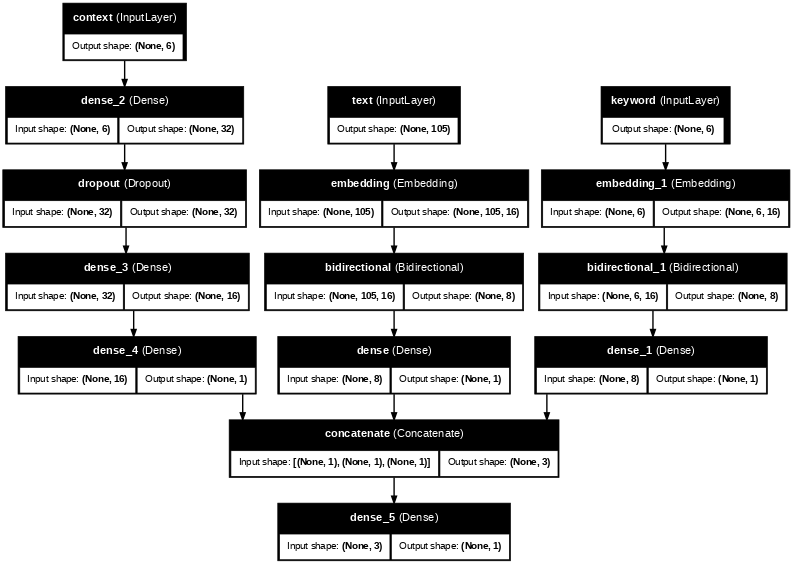

In [68]:
plot_model(model_base, show_layer_names=True, show_shapes=True, dpi=50)

## Let's train

In [115]:
def train_model(model, train_data, val_data, epochs=100, version="base"):
    checkpoint_filepath = f'/kaggle/working/models/model_{version}.keras'
    checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', save_best_only=True)
    reduce = ReduceLROnPlateau(monitor='val_loss', patience=6, verbose=1)
    early = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    csvlogger = CSVLogger(f"/kaggle/working/histories/history_model_{version}.csv", separator=',')
    
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=[BinaryAccuracy()])
    history = model.fit(train_data,
                        validation_data=val_data,
                        epochs=epochs,
                        callbacks=[reduce, early, checkpoint, csvlogger],
                        class_weight=class_weight
                       )
    return history
    
history_base = train_model(model=model_base,
                           train_data=train_data_tokenized,
                           val_data=val_data_tokenized,
                           epochs=200,
                           version="base"
                          )

Epoch 1/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - binary_accuracy: 0.4228 - loss: 0.8434 - val_binary_accuracy: 0.4242 - val_loss: 0.8515 - learning_rate: 1.0000e-04
Epoch 2/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - binary_accuracy: 0.4228 - loss: 0.7696 - val_binary_accuracy: 0.4242 - val_loss: 0.7718 - learning_rate: 1.0000e-04
Epoch 3/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - binary_accuracy: 0.4228 - loss: 0.7241 - val_binary_accuracy: 0.4242 - val_loss: 0.7384 - learning_rate: 1.0000e-04
Epoch 4/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - binary_accuracy: 0.4228 - loss: 0.7069 - val_binary_accuracy: 0.4242 - val_loss: 0.7231 - learning_rate: 1.0000e-04
Epoch 5/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - binary_accuracy: 0.4228 - loss: 0.7001 - val_binary_accuracy: 0.4242 - val_loss: 0.7152 - learning_rate: 1.0000e-04
Epoch 6/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - binary_accuracy: 0.4228 - loss: 0.6962 - val_binary_accuracy: 0.4242 - val_loss: 0.7

## Visualizing the metrics over training epochs of the baseline model

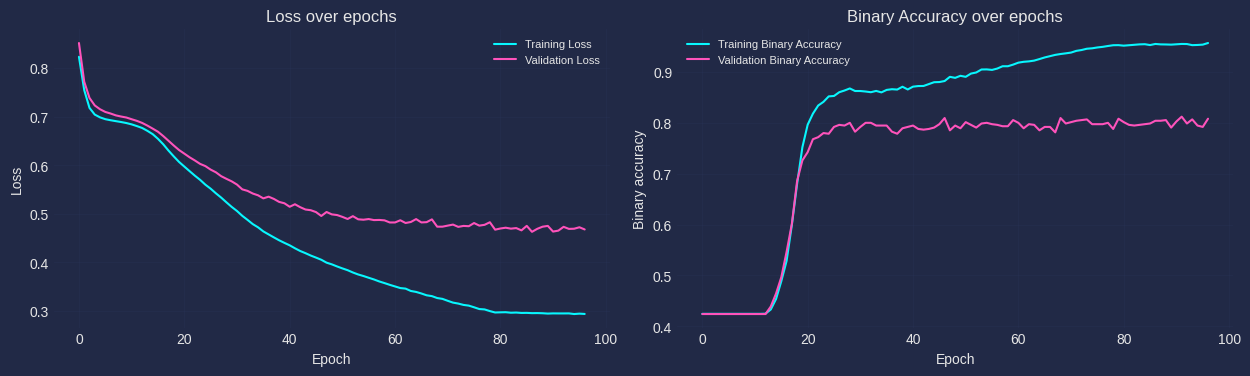

In [118]:
def delete_empty_subplots(fig, axs):
    for ax_row in axs:
        for ax in ax_row:
            if ax.title.get_text() == "":
                fig.delaxes(ax)
    return fig, axs

def show_history(version, parameters=None):
    df_hist = pd.read_csv(f"/kaggle/working/histories/history_model_{version}.csv")
    fig, axs = plt.subplots(2, 4, figsize=(25, 7))

    for i, col in enumerate(parameters):
        plt.subplot(2, 4, i+1)
        param = col[0].replace('_', ' ').title()
        plt.plot(df_hist.index, df_hist[col[0]], label=f"Training {param}")
        plt.plot(df_hist.index, df_hist[col[1]], label=f"Validation {param}")
        plt.ylabel(col[0].capitalize().replace("_", " "))
        plt.xlabel("Epoch")
        plt.legend(fontsize=8)
        plt.grid(True, alpha=0.3, which="both")
        plt.title(f"{param} over epochs")

    fig, axs = delete_empty_subplots(fig, axs)
    plt.tight_layout()
    plt.show()
    return
    
show_history(version="base", parameters=[["loss", "val_loss"],["binary_accuracy", "val_binary_accuracy"]])

## Evaluating the baseline model

In [119]:
model_base.evaluate(test_data_tokenized)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.7934 - loss: 0.4947


[0.49476027488708496, 0.7892617583274841]

# Fine-Tuning with the BERT architecture (Bidirectional Encoder Representations from Transformers)

<img src="https://miro.medium.com/v2/resize:fit:828/format:webp/1*9T7r1yXe5zUcobWDQTPSdw.png" width=600>

## Creating the dataset for the BERT model
### Selecting the useful columns

In [120]:
X_train_clean = X_train.loc[:, "text"]
X_val_clean = X_val.loc[:, "text"]
X_test_clean = X_test.loc[:, "text"]

X_train_clean

id
3015                                     I feel like death
276      #reuters Twelve feared killed in Pakistani air...
3075     real magic in real life:\n\nwomen went missing...
2209     Emergency Response and Hazardous Chemical Mana...
996      SHOUOUT TO @kasad1lla CAUSE HER VOCALS ARE BLA...
                               ...                        
10137    Ancient Mayan Tablet with Hieroglyphics Honors...
1061        @KatRamsland Yes I'm a bleeding heart liberal.
3509     MP trains derailment: Û÷ItÛªs the freakiest ...
4022     DISASTER AVERTED: Police kill gunman with 'hoa...
1501     US Û÷Institute Of PeaceÛª Chairman Wants Rus...
Name: text, Length: 5957, dtype: object

### Creating a Tensorflow Dataset

In [133]:
train_data_bert = Dataset.from_tensor_slices(X_train_clean.values)
train_labels = Dataset.from_tensor_slices(y_train.values)

val_data_bert = Dataset.from_tensor_slices(X_val_clean.values)
val_labels = Dataset.from_tensor_slices(y_val.values)

test_data_bert = Dataset.from_tensor_slices(X_test_clean.values)
test_labels = Dataset.from_tensor_slices(y_test.values)

train_data_bert = Dataset.zip((train_data_bert, train_labels))
val_data_bert = Dataset.zip((val_data_bert, val_labels))
test_data_bert = Dataset.zip((test_data_bert, test_labels))

AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32

preset = "bert_small_en_uncased"
preprocessor = BertPreprocessor.from_preset(preset, trainable=False)

train_data_bert = train_data_bert.map(preprocessor).batch(batch_size).prefetch(buffer_size=AUTOTUNE)
val_data_bert = val_data_bert.map(preprocessor).batch(batch_size).prefetch(buffer_size=AUTOTUNE)
test_data_bert = test_data_bert.map(preprocessor).batch(batch_size).prefetch(buffer_size=AUTOTUNE)

## BERT model architecture

In [141]:
def get_bert_model(preset):
    tf.keras.backend.clear_session()
    tokens_ids = Input(shape=(512,), name='token_ids')
    padding_mask = Input(shape=(512,), name='padding_mask')
    segment_ids = Input(shape=(512, ), name='segment_ids')
    encoder = BertBackbone.from_preset(preset)
    for i, layer in enumerate(encoder.layers):
        encoder.layers[i].trainable = True
    outputs = encoder({'token_ids':tokens_ids, 'padding_mask':padding_mask, 'segment_ids':segment_ids})
    my_net = outputs["pooled_output"]
    
    my_net = Dense(32, activation="relu")(my_net)
    my_net = Dropout(0.4)(my_net)
    
    my_net = Dense(32, activation="relu")(my_net)
    my_net = Dropout(0.4)(my_net)
    my_net = Dense(1, activation="sigmoid")(my_net)
    return Model(inputs={'token_ids':tokens_ids, 'padding_mask':padding_mask, 'segment_ids':segment_ids}, outputs=my_net)
    
model_bert = get_bert_model(preset)
model_bert.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer) │ (None, 512)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ segment_ids (InputLayer)  │ (None, 512)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_ids (InputLayer)    │ (None, 512)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_backbone             │ [(None, 512), (None,   │     28,763,648 │ padding_mask[0][0],    │
│ (BertBackbone)            │ 512, 512)]             │                │ segment_ids[0][0],     │
│                           │                        │                │ token_ids[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │         16,416 │ bert_backbone[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 32)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │          1,056 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 32)             │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │             33 │ dropout_5[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 28,781,153 (109.79 MB)

 Trainable params: 28,781,153 (109.79 MB)

 Non-trainable params: 0 (0.00 B)

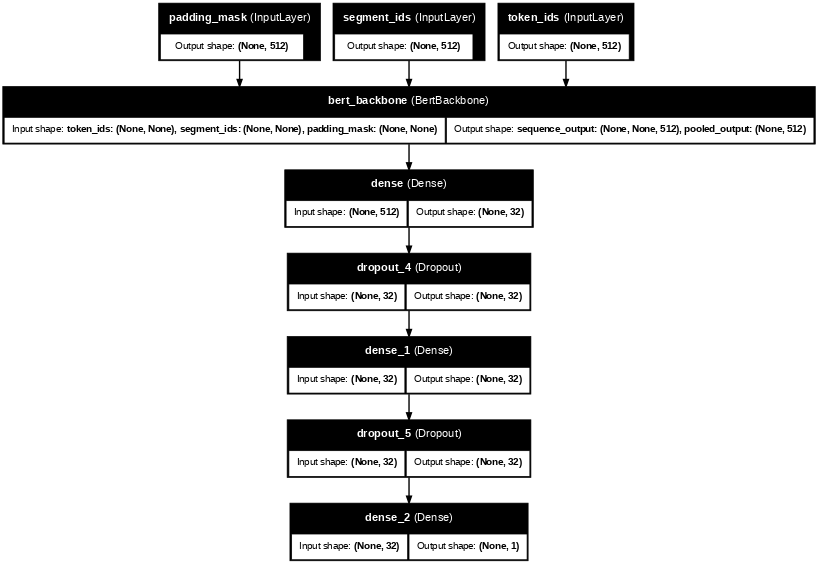

In [142]:
plot_model(model_bert, show_layer_names=True, show_shapes=True, dpi=50)

## Let's train the BERT model

In [143]:
def train_model(model, train_data, val_data, epochs=100, version="base"):
    checkpoint_filepath = f'/kaggle/working/models/model_{version}.keras'
    checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', save_best_only=True)
    reduce = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)
    early = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
    csvlogger = CSVLogger(f"/kaggle/working/histories/history_model_{version}.csv", separator=',')
    
    model.compile(optimizer=Adam(learning_rate=5e-5), loss = 'binary_crossentropy', metrics = [BinaryAccuracy()])
    history = model.fit(train_data,
                        validation_data=val_data,
                        epochs=epochs,
                        callbacks=[reduce, early, checkpoint, csvlogger],
                        class_weight=class_weight
                       )
    return history
    
history_bert = train_model(model_bert, train_data_bert, val_data_bert, epochs=20, version="bert")

Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 96s 379ms/step - binary_accuracy: 0.6002 - loss: 0.6568 - val_binary_accuracy: 0.8040 - val_loss: 0.4856 - learning_rate: 5.0000e-05
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 52s 279ms/step - binary_accuracy: 0.7611 - loss: 0.5165 - val_binary_accuracy: 0.8282 - val_loss: 0.4405 - learning_rate: 5.0000e-05
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 52s 279ms/step - binary_accuracy: 0.8259 - loss: 0.4376 - val_binary_accuracy: 0.8443 - val_loss: 0.4038 - learning_rate: 5.0000e-05
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 51s 269ms/step - binary_accuracy: 0.8551 - loss: 0.3662 - val_binary_accuracy: 0.8309 - val_loss: 0.5031 - learning_rate: 5.0000e-05
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 51s 269ms/step - binary_accuracy: 0.8922 - loss: 0.2995 - val_binary_accuracy: 0.8121 - val_loss: 0.5498 - learning_rate: 5.0000e-05
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - binary_accuracy: 0.9234 - loss: 0.2250
Epoch 6: ReduceLROnPlateau reducing lear

## Visualizing the metrics over training epochs of the BERT model

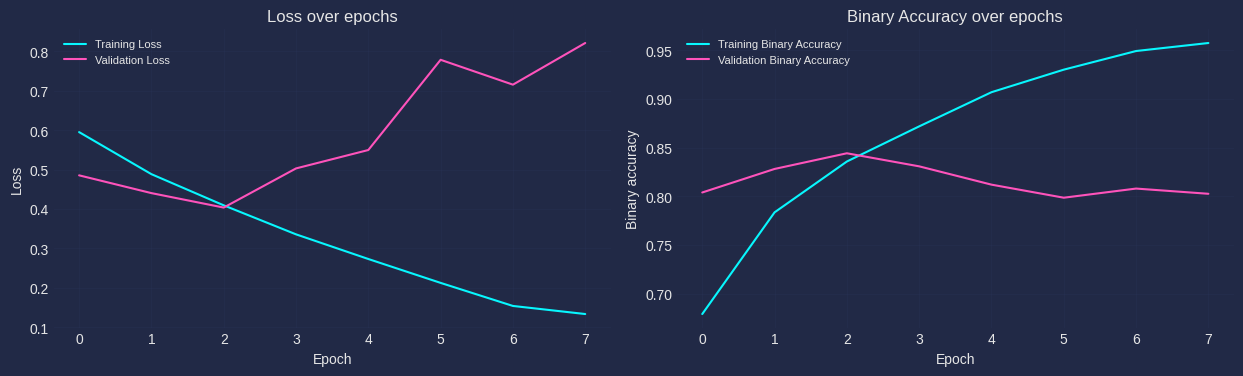

In [144]:
show_history(version="bert", parameters=[["loss", "val_loss"],["binary_accuracy", "val_binary_accuracy"]])

## Evaluating the BERT model

In [165]:
model_bert.evaluate(test_data_bert)

24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - binary_accuracy: 0.8232 - loss: 0.4243


[0.44635578989982605, 0.8228188157081604]

In [146]:
import cloudpickle

with open('preprocessor.bin', 'wb') as f_out:
    cloudpickle.dump(preprocessor, f_out)

# Evaluation metrics

## Comparison table

In [147]:
def get_scores(y_true, y_pred, y_pred_proba):
    return {'AUC_ROC':roc_auc_score(y_true, y_pred_proba),
           'F1_Score':f1_score(y_true, y_pred, average='weighted'),
           'Accuracy':accuracy_score(y_true, y_pred),
           'Precision':precision_score(y_true, y_pred, average='weighted'),
           'Recall':recall_score(y_true, y_pred, average='weighted')}

scores = []

y_test_pred_proba_base = model_base.predict(test_data_tokenized, verbose=0)
y_test_pred_base = tf.math.round(y_test_pred_proba_base)
scores.append(get_scores(y_test, y_test_pred_base, y_test_pred_proba_base))

y_test_pred_proba_bert = model_bert.predict(test_data_bert, verbose=0)
y_test_pred_bert = tf.math.round(y_test_pred_proba_bert)
scores.append(get_scores(y_test, y_test_pred_bert, y_test_pred_proba_bert))

comparison = pd.DataFrame(data=scores, index=["Baseline Model", "BERT model"], columns=["AUC_ROC", "F1_Score", "Accuracy", "Precision", "Recall"])
comparison.style.highlight_max(color = 'green', axis = 0).highlight_min(color = 'red', axis = 0)

,AUC_ROC,F1_Score,Accuracy,Precision,Recall
Baseline Model,0.827218,0.788396,0.789262,0.788371,0.789262
BERT model,0.869759,0.820511,0.822819,0.824253,0.822819


## Confusion matrix

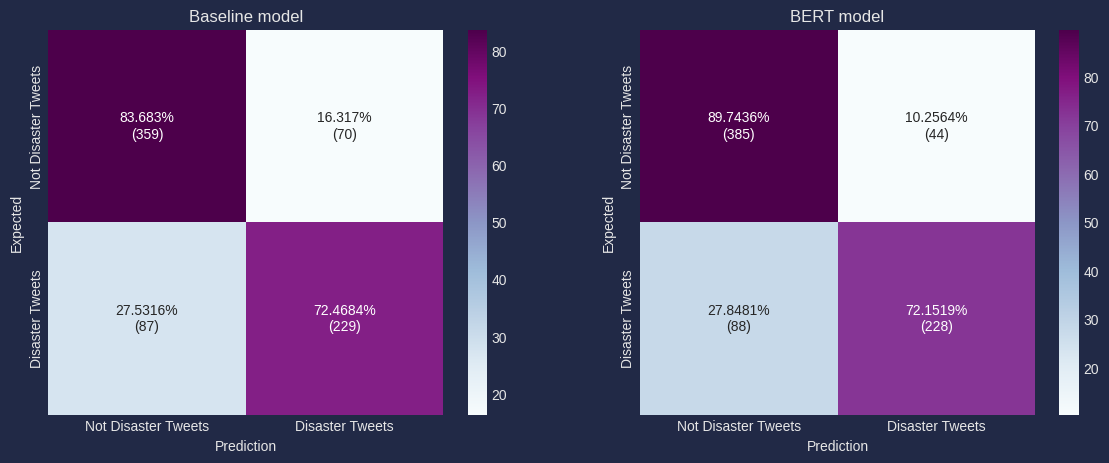

In [148]:
def my_cm(y_true, y_pred, title):
    cm_val = confusion_matrix(y_true, y_pred)
    cm_pgs = np.round(confusion_matrix(y_true, y_pred, normalize='true')*100, 4)

    formatted_text = (np.asarray([f"{pgs}%\n({val})" for val, pgs in zip(cm_val.flatten(), cm_pgs.flatten())])).reshape(2, 2)

    sns.heatmap(cm_pgs, annot=formatted_text, fmt='', cmap='BuPu', yticklabels=classes, xticklabels=classes)
    plt.title(title)
    plt.xlabel("Prediction")
    plt.ylabel("Expected")
    return

classes = ["Not Disaster Tweets", "Disaster Tweets"]
plt.subplots(1, 2, figsize=(14, 5))

plt.subplot(1, 2, 1)
my_cm(y_test, y_test_pred_base, title="Baseline model")

plt.subplot(1, 2, 2)
my_cm(y_test, y_test_pred_bert, title="BERT model")

# Generating the submission file
## Loading a sample submission

In [172]:
pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv").head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


## Loading the test file

In [150]:
df_submission = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv", usecols=["id", "text"])
df_submission.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


## Classifying the tweets in the test file

In [155]:
preprocessed_text = preprocessor(df_submission.text)
prediction = model_bert.predict(preprocessed_text)
prediction = tf.cast(tf.math.round(prediction), tf.uint8)
prediction

102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step


<tf.Tensor: shape=(3263, 1), dtype=uint8, numpy=
array([[0],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], dtype=uint8)>

## Creating the submission file

In [160]:
df_submission["target"] = prediction
submission = df_submission.loc[:, ["id", "target"]]
submission.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1


## Save the submission file

In [161]:
submission.to_csv("submission.csv", index=False)

## My leaderboard position in the competition
Currently, my position is #217
<img src="https://i.postimg.cc/YC13wYGQ/imagen-2025-01-25-220540659.png">

### Thank you for your time! 😃